In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install koreanize-matplotlib
import koreanize_matplotlib

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 46.1 MB/s eta 0:00:00


In [134]:
id = pd.read_csv('/content/drive/MyDrive/최종프로젝트/SDB2_A_ID.csv')                   # 차주정보

rlps = pd.read_csv('/content/drive/MyDrive/최종프로젝트/SDB2_I_CT_RLPS.csv')            # 보험계약관계자정보
cont = pd.read_csv('/content/drive/MyDrive/최종프로젝트/SDB2_I_CT_CONT_PVT.csv')        # 보험계약정보
mgg = pd.read_csv('/content/drive/MyDrive/최종프로젝트/SDB2_I_CT_MGG_PVT.csv')          # 보험담보정보

accd = pd.read_csv('/content/drive/MyDrive/최종프로젝트/SDB2_I_PT_ACCD.csv')            # 청구사고정보
claim_cont = pd.read_csv('/content/drive/MyDrive/최종프로젝트/SDB2_I_PT_CONT.csv')      # 청구계약정보
pmnt = pd.read_csv('/content/drive/MyDrive/최종프로젝트/SDB2_I_PT_PMNT.csv')            # 청구지급사유정보
pmntdtl = pd.read_csv('/content/drive/MyDrive/최종프로젝트/SDB2_I_PT_PMNTDTL.csv')      # 청구지급상세사유정보
vctm = pd.read_csv('/content/drive/MyDrive/최종프로젝트/SDB2_I_PT_VCTM.csv')            # 청구피해자물정보

In [2]:
rlps = pd.read_csv('/content/drive/MyDrive/최종프로젝트/SDB2_I_CT_RLPS.csv')            # 보험계약관계자정보
cont = pd.read_csv('/content/drive/MyDrive/최종프로젝트/SDB2_I_CT_CONT_PVT.csv')        # 보험계약정보

In [ ]:
cont2 = pd.read_csv('/content/drive/MyDrive/최종프로젝트/v2_cont_merge_ver2_(drop).csv')


# 3보험계약정보 SDB2_I_CT_COUNT_PVT => cont
### 처리내용
- 드랍 리스트: 업권코드, 인수심사결과코드, 진단계약여부, 계약체결/해지/시기/종기/실효/부활월, 연월컬름들(20개+_정도)   
=> cont_pre1

- 단체보험여부: 1(단체, 17578건) 값을 drop한 후, 컬럼 자체 삭제
    - 회사/기관에서 소속된 사람들을 보험에 가입시켜놓는  
=>cont_pre2
  
- 증권번호: 증권번호 같은데 차주가 여러명인 경우 (70,998건) drop  
=>///70,998건이아님 6556으로 나옴   
=>cont_pre3
- 증권번호가 같은데 차주가 여러명인 증권번호 모음   
=>rlps_2upper

- 보험종류코드: 차원 축소
    - 사망류: 종신(01), 정기(02)
    - 질병류: 질병(03), 암(05)
    - 상해보험(04) 단독
    - 어린이보험(07), 실비보험(16)
    - 운전자(13) 단독
    - 여행자(14) 단독
    - 연금저축(09), 연금(10), 저축(11)
    - 기타: 간병(06), 치아(08), 교육(12), 골프(15), 기타보험(99)
    - 값 없음(0건): 자동차(17), 배상책임(19). 무시.
    - 주계약상태코드: 차원 축소
    - 01 정상(심사중) -> 날림
    - 02 정상
    - 03청약철회, 06소멸, 07해지, 08무효, (09, 10)취소 -> 보험료 환불 + 보험이 해지됨
    - 04 실효
    - 05 만기


- 납입보험료: 같은 증권번호(POL_SN)에 열이 여러개인 경우(e.g., 보험료가 변경된 경우) 평균값
- 납입주기코드, 납입기간: 중요. 그대로 둠.
- 가입경로코드: 나~~중에 인사이트 발굴용 (액션플랜쯤)

## 0번 전처리
## 하나의 증권번호에 일정 유효시점에 두개이상이 유효할 때

In [3]:
pre_0 = cont.groupby('POL_SN')[['YM_201806', 'YM_201807', 'YM_201808',
       'YM_201809', 'YM_201810', 'YM_201811', 'YM_201812', 'YM_201901',
       'YM_201902', 'YM_201903', 'YM_201904', 'YM_201905', 'YM_201906',
       'YM_201907', 'YM_201908', 'YM_201909', 'YM_201910', 'YM_201911',
       'YM_201912', 'YM_202001', 'YM_202002', 'YM_202003', 'YM_202004',
       'YM_202005', 'YM_202006']].sum().reset_index()

1928	이사람  하나의 증권번호에 유요한 계약의 개수가 많다. => 저번 문의에서 답변받은 결과를 통해 이상치로 간주
뒤에서 발견했지만 공식적으로 인정된 이상치이므로 가장 앞계에서 제거
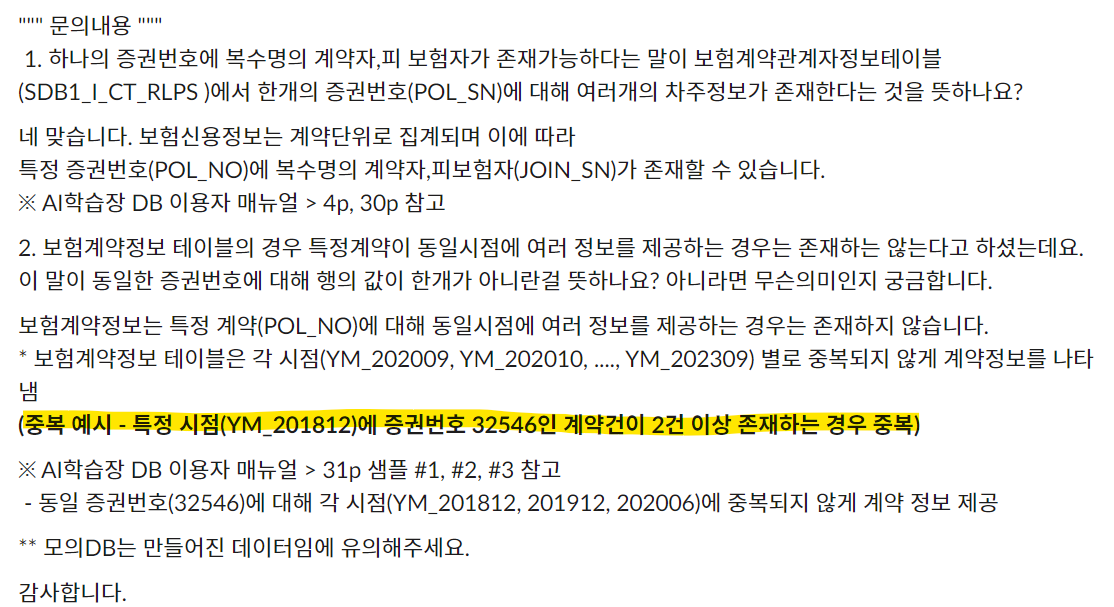


In [4]:
#이상치만 모으기
pre = pre_0[pre_0['YM_202006']>1]#13882개의 증권번호
display(pre)

#이상치 제거
cont = cont[~cont['POL_SN'].isin(pre['POL_SN'])]
display(cont)

,POL_SN,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006
22,573,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
33,1146,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
52,1928,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
68,2578,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
84,3203,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244170,9995198,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
244185,9995730,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
244188,9995942,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
244197,9996385,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


,SCTR_CD,POL_SN,IS_GRP_INS,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006
0,6,3023157,0,3,7,200806,200903,200806,200906,999912,999912,10,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,8,2067576,0,1,2,201012,999912,201012,999912,999912,999912,33,2,20,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,6,7995898,0,7,2,201409,999912,201409,999912,999912,999912,52,2,30,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
3,8,9743978,0,4,7,201604,201704,201604,201704,999912,999912,170,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,6,9040681,0,4,2,201804,999912,201804,204804,999912,202006,43,2,25,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368476,8,2330274,1,4,5,201905,999912,201905,202005,999912,999912,59,3,1,0,1,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
368478,8,6242384,0,7,2,201212,999912,201212,203812,999912,999912,47,2,10,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
368480,6,6050915,0,7,7,200902,201107,200902,201902,999912,999912,15,2,10,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
368481,6,9901184,0,14,2,201809,999912,201809,201902,999912,999912,96,1,0,0,1,5,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
#제거됐나 확인
cont[cont['POL_SN']==1928]

,SCTR_CD,POL_SN,IS_GRP_INS,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006


## 1번 전처리
##사용컬럼만 남긴df => cont_pre1

In [ ]:
'''cont.columns
cont_use_list=['POL_SN','IS_GRP_INS', 'INS_GBN_CD', 'INS_CT_STAT_CD','CT_PY_AMT','CT_PY_CYCLE_CD', 'CT_PY_PD', 'CT_CHNL_CD','YM_202006' ]
# 사용하는 보험 컬럼 (증권번호 , 단체보험여부, 보험중류코드, 주계약상태코드 , 납입보험료, 납입기간, 가입경로)

cont_pre1 = cont[cont_use_list]
cont_pre1'''

,POL_SN,IS_GRP_INS,INS_GBN_CD,INS_CT_STAT_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,CT_CHNL_CD,YM_202006
0,3023157,0,3,7,10,2,1,6,1
1,2067576,0,1,2,33,2,20,3,1
2,7995898,0,7,2,52,2,30,1,0
3,9743978,0,4,7,170,3,1,4,1
4,9040681,0,4,2,43,2,25,1,1
...,...,...,...,...,...,...,...,...,...
368476,2330274,1,4,5,59,3,1,99,1
368478,6242384,0,7,2,47,2,10,1,1
368480,6050915,0,7,7,15,2,10,6,1
368481,9901184,0,14,2,96,1,0,5,0


## 2번 전처리
## 단체 날리기&단체보험컬럼 날리기 => cont_pre2

In [6]:
cont_pre2 = cont.loc[cont['IS_GRP_INS']==0]
cont_pre2.drop(columns =['IS_GRP_INS'], inplace=True)
cont_pre2

<ipython-input-6-4e6825af7b4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_pre2.drop(columns =['IS_GRP_INS'], inplace=True)


,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006
0,6,3023157,3,7,200806,200903,200806,200906,999912,999912,10,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,8,2067576,1,2,201012,999912,201012,999912,999912,999912,33,2,20,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,6,7995898,7,2,201409,999912,201409,999912,999912,999912,52,2,30,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
3,8,9743978,4,7,201604,201704,201604,201704,999912,999912,170,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,6,9040681,4,2,201804,999912,201804,204804,999912,202006,43,2,25,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368475,8,8914008,11,2,201901,999912,201901,202901,999912,999912,360,2,5,0,1,4,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
368478,8,6242384,7,2,201212,999912,201212,203812,999912,999912,47,2,10,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
368480,6,6050915,7,7,200902,201107,200902,201902,999912,999912,15,2,10,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
368481,6,9901184,14,2,201809,999912,201809,201902,999912,999912,96,1,0,0,1,5,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 3번 전처리
## 차주가 여러개인 증권번호 날리기 => cont_pre3

### 증권번호에서 차주가 여러명인경우 제거
###(여러개의 차주번호를 가진 증권번호 제거 )
제거하는 이유 : 보험계약테이블(cont)에는 차주 번호가없어 증권번호로 join 해야하는데 계약테이블(rlps)에 증권번호에 여러개의 차주가 존재해 어떤 차주인지 특정할 수 없는 문제 발생. => 이를 해결하기위해 제거.

1. 관계테이블에서 증권번호별 두개이상의 차주를 가진 증권번호를 구함
2. 계약정보테이블과 비교해서 두개이상의 차주를 가진 증권번호는 drop
Q. 그럼 현재 계약정보테이블에 해당 증권번호는 없는 상태인데 보험담보테이블에는 해당 증권번호가 있는상태이다.

=>   **계약정보가 없는 보험 담보내용인데...같이 처리해줘야하는게 아닐까? * 내일 건의해보자**  
=> 해당 증권번호를 담보내용에서도 제거하기로 결정!

차주가 두개인 경우도 결국 특정할 수 없는것은 마찬가지 이므로
증권번호당 차주번호 1개 가진것 외에는 제거

- 프로세스 :
- 1.RLPS테이블에서 POL_SN' 증권번호로 groupby 해서 하나의 증권번호에 몇 개 차주가 카운트 됐는지 확인
- 2. 3개 이상인 경우만 따로 추출 -> rlps_3upper
     2개 이상인 경우 따로 추출 rlps_2upper
- 3. 증권번호 별 케이스 확인 ->
- 4. 계약정보 테이블에서 같은 증권번호로 계약이 몇건 있는지 확인

###RLPS 테이블 전처리 - 개인여부
- 개인여부: 1(개인)인 것만 남기기

In [7]:
#rlps 개인만 남기기
rlps = rlps[rlps['IS_INDIV']==1]

###RLPS 테이블 전처리 -2개이상 차주를 가진 증권번호
- 차주번호가 2개이상인 증권번호 구하기

In [8]:
#증권번호로 groupby 해서 하나의 증권번호가 몇 개 카운트 됐는지 확인
#하나의 증권번호에 차주번호가 여러개 존재하는 경우
rlps_group = rlps.groupby('POL_SN')['JOIN_SN'].nunique().reset_index()
rlps_group

#2개이상
rlps_2upper = rlps_group[rlps_group['JOIN_SN']>1][['POL_SN']]
display(rlps_2upper)#증권번호 별 차주개수가 2개 이상인 것 증권번호 고유값 1162

,POL_SN
70,2578
313,12294
616,26458
893,37793
1513,61797
...,...
247202,9954722
247515,9967220
247522,9967439
247685,9974859


In [9]:
#하나의 증권번호에 2개이상의 여러 차주가 있는경우 #4744개
rlps[rlps['POL_SN'].isin(rlps_2upper['POL_SN'])].sort_values(by='POL_SN')

,JOIN_SN,JOIN_SN_TYP,SCTR_CD,COM_SN,IS_ME,POL_SN,CT_RLPS_GBN_CD,CT_IN_RLTN_CD,IS_INDIV,GIS_CD
224878,20116,1,6,520294,0,2578,I,99,1,21
49142,659233,1,6,6637197,0,2578,I,99,1,21
216635,928030,1,6,6515672,0,12294,I,99,1,99
209632,782905,1,6,3837179,0,12294,I,99,1,99
28550,71198,1,6,4287104,0,12294,I,99,1,99
...,...,...,...,...,...,...,...,...,...,...
5274,1455142,1,6,1499015,0,9967439,I,99,1,99
169756,1430292,1,6,7206535,0,9974859,I,99,1,99
200723,605578,1,6,8317102,0,9974859,I,99,1,99
218845,1343670,1,6,6950985,0,9997283,I,99,1,99


In [10]:
#관계자 정보 테이블 rlps
rlps[rlps['POL_SN']==37793]

,JOIN_SN,JOIN_SN_TYP,SCTR_CD,COM_SN,IS_ME,POL_SN,CT_RLPS_GBN_CD,CT_IN_RLTN_CD,IS_INDIV,GIS_CD
97805,1683555,1,6,7335282,0,37793,I,99,1,99
100740,1477127,1,6,8388762,0,37793,I,99,1,99
167626,292220,1,6,7512929,0,37793,I,99,1,99
360398,64951,1,6,2499848,0,37793,I,99,1,99


In [11]:
#계약정보테이블에서 rlps에서 차주가 2개이상인 증권번호삭제할예정
cont_pre2[cont_pre2['POL_SN'].isin(rlps_2upper['POL_SN'])].sort_values(by='POL_SN')

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006
347660,6,95735,4,7,200612,201204,200612,202111,999912,999912,77,2,15,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
82395,6,1440728,5,2,201608,999912,201608,207708,999912,999912,50,2,61,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
169138,6,5906770,14,10,201410,999912,201411,201411,201410,999912,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
184603,6,7273699,4,2,201204,999912,201204,207804,999912,999912,200,2,20,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
248027,6,7273699,4,2,201204,999912,201204,207804,999912,999912,160,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
172600,6,9304353,14,5,200908,999912,200908,200908,999912,999912,26,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### cont테이블에서 두개 차주 제거

In [12]:
#계약정보테이블에서 rlps에서 차주가 2개이상인 증권번호삭제할예정
cont_pre3 = cont_pre2[~cont_pre2['POL_SN'].isin(rlps_2upper['POL_SN'])]
cont_pre3

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006
0,6,3023157,3,7,200806,200903,200806,200906,999912,999912,10,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,8,2067576,1,2,201012,999912,201012,999912,999912,999912,33,2,20,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,6,7995898,7,2,201409,999912,201409,999912,999912,999912,52,2,30,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
3,8,9743978,4,7,201604,201704,201604,201704,999912,999912,170,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,6,9040681,4,2,201804,999912,201804,204804,999912,202006,43,2,25,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368475,8,8914008,11,2,201901,999912,201901,202901,999912,999912,360,2,5,0,1,4,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
368478,8,6242384,7,2,201212,999912,201212,203812,999912,999912,47,2,10,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
368480,6,6050915,7,7,200902,201107,200902,201902,999912,999912,15,2,10,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
368481,6,9901184,14,2,201809,999912,201809,201902,999912,999912,96,1,0,0,1,5,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
#차주 두개인 증권번호가 있는지 확인해봄
cont_pre3[cont_pre3['POL_SN'].isin(rlps_2upper['POL_SN'])].sort_values(by='POL_SN')

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006


## 4번 전처리 => cont_pre4
## 보험종류코드: 차원 축소  INS_GBN_CD=> REDUCE_GBN_CD
  1- 사망류: 종신(01), 정기(02)  
    2- 질병류: 질병(03), 암(05)  
    3- 상해보험(04) 단독  
    4- 어린이보험(07), 실비보험(16)  
    5- 운전자(13) 단독  
    6- 여행자(14) 단독  
    7- 연금저축(09), 연금(10), 저축(11)  
    8- 기타: 간병(06), 치아(08), 교육(12), 골프(15), 기타보험(99)   
    - 값 없음(0건): 자동차(17), 배상책임(19). 무시.  

In [ ]:
cont_pre3['INS_GBN_CD'].info()

<class 'pandas.core.series.Series'>
Index: 297133 entries, 0 to 368482
Series name: INS_GBN_CD
Non-Null Count   Dtype
--------------   -----
297133 non-null  int64
dtypes: int64(1)
memory usage: 4.5 MB


In [14]:
#범주 축소
def GBN_CN_reduce(x):
  match x:
    case 1|2:
        return 1
    case 3|5:
        return 2
    case 4:
        return 3
    case 7|16:
        return 4
    case 13:
        return 5
    case 14:
        return 6
    case 9|10|11:
        return 7
    case 6|8|12|15|99:
        return 8
    case 18:
        return 9

cont_pre3['reduce_GBN_CD'] = cont_pre3['INS_GBN_CD'].apply(GBN_CN_reduce)
cont_pre3

<ipython-input-14-c715f1248872>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_pre3['reduce_GBN_CD'] = cont_pre3['INS_GBN_CD'].apply(GBN_CN_reduce)


,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD
0,6,3023157,3,7,200806,200903,200806,200906,999912,999912,10,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2
1,8,2067576,1,2,201012,999912,201012,999912,999912,999912,33,2,20,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,6,7995898,7,2,201409,999912,201409,999912,999912,999912,52,2,30,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,4
3,8,9743978,4,7,201604,201704,201604,201704,999912,999912,170,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3
4,6,9040681,4,2,201804,999912,201804,204804,999912,202006,43,2,25,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368475,8,8914008,11,2,201901,999912,201901,202901,999912,999912,360,2,5,0,1,4,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7
368478,8,6242384,7,2,201212,999912,201212,203812,999912,999912,47,2,10,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4
368480,6,6050915,7,7,200902,201107,200902,201902,999912,999912,15,2,10,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4
368481,6,9901184,14,2,201809,999912,201809,201902,999912,999912,96,1,0,0,1,5,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6


## 5번째 전처리
## 주계약상태코드: 차원 축소 INS_CT_STAT_CD
- 01 정상(심사중) -> 날림  
1 - 02 정상  
2 - 03청약철회, 06소멸, 07해지, 08무효, (09, 10)취소 -> 보험료 환불 + 보험이 해지됨  
3 - 04 실효    
4 - 05 만기  


In [ ]:
cont_pre3['INS_CT_STAT_CD'].info()

<class 'pandas.core.series.Series'>
Index: 297133 entries, 0 to 368482
Series name: INS_CT_STAT_CD
Non-Null Count   Dtype
--------------   -----
297133 non-null  int64
dtypes: int64(1)
memory usage: 4.5 MB


In [15]:
#심사중 (1)삭제 =>con_pre4
cont_pre4 = cont_pre3[~(cont_pre3['INS_CT_STAT_CD']==1)]
cont_pre4['INS_CT_STAT_CD'].unique()

array([ 7,  2,  6,  5,  4,  3, 10,  9,  8])

In [16]:
#범주 축소
def get_STAT_CD(x):
  match x:
    case 2:
      return 1
    case 3|6|7|8|9|10:
      return 2
    case 4:
      return 3
    case 5:
      return 4

cont_pre4['reduce_STAT_CD'] = cont_pre4['INS_CT_STAT_CD'].apply(get_STAT_CD)
cont_pre4

<ipython-input-16-b2f44aea6c0f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_pre4['reduce_STAT_CD'] = cont_pre4['INS_CT_STAT_CD'].apply(get_STAT_CD)


,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD
0,6,3023157,3,7,200806,200903,200806,200906,999912,999912,10,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2
1,8,2067576,1,2,201012,999912,201012,999912,999912,999912,33,2,20,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,6,7995898,7,2,201409,999912,201409,999912,999912,999912,52,2,30,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,4,1
3,8,9743978,4,7,201604,201704,201604,201704,999912,999912,170,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2
4,6,9040681,4,2,201804,999912,201804,204804,999912,202006,43,2,25,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368475,8,8914008,11,2,201901,999912,201901,202901,999912,999912,360,2,5,0,1,4,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,1
368478,8,6242384,7,2,201212,999912,201212,203812,999912,999912,47,2,10,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,1
368480,6,6050915,7,7,200902,201107,200902,201902,999912,999912,15,2,10,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,2
368481,6,9901184,14,2,201809,999912,201809,201902,999912,999912,96,1,0,0,1,5,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1


In [ ]:
'''#사용컬럼만 가져오기
cont_pre5 = cont_pre4[['POL_SN','reduce_GBN_CD','reduce_STAT_CD','YM_202006','CT_CHNL_CD','CT_PY_AMT','CT_PY_CYCLE_CD','CT_PY_PD']]
cont_pre5'''

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD
0,3023157,2,2,1,6,10,2,1
1,2067576,1,1,1,3,33,2,20
2,7995898,4,1,0,1,52,2,30
3,9743978,3,2,1,4,170,3,1
4,9040681,3,1,1,1,43,2,25
...,...,...,...,...,...,...,...,...
368475,8914008,7,1,1,4,360,2,5
368478,6242384,4,1,1,1,47,2,10
368480,6050915,4,2,1,6,15,2,10
368481,9901184,6,1,0,5,96,1,0


## 6번 전처리
## 납입보험료: 같은 증권번호(POL_SN)에 열이 여러개인 경우(e.g., 보험료가 변경된 경우) 평균값

- 한 증권번호에 대해서 로우가 2개 이상인 증권번호 개수 65001개(g)
- 처리방법
- 원래의 테이블 (cont_pre5)에서 추출한 테이블 (g)로 필터 걸어서 데이터 살펴보기=>170082개
- 증권번호 별 'CT_PY_AMT'평균내기

***로우가 두개인 경우 3가지***
- 보험료 동결/약관 바뀐경우
- 보험료 인상
- 보험상태 변경(개인보험->단체)

In [17]:
#(1) 각 증권번호별 보험료 평균 구한 후 원래 납입금액 컬럼 삭제

mean_AMT = cont_pre4.groupby('POL_SN')['CT_PY_AMT'].mean().reset_index()
mean_AMT = mean_AMT.rename(columns={'CT_PY_AMT': 'mean_AMT'})

cont_pre5 = pd.merge(cont_pre4,mean_AMT, on='POL_SN')
#cont_pre5 = cont_pre5.drop('CT_PY_AMT', axis=1)

In [18]:
#(2)cont_pre5 두개로 쪼개기
g = cont_pre5.groupby('POL_SN').size().reset_index()
#각 증권번호별 로우 개수

#증권번호별 로우가 1개인 것 SN_1
#증권번호별 로우가 2개 이상인 것 SN_2up
g_2 = g[g[0]>1]

SN_1 = cont_pre5[~cont_pre5['POL_SN'].isin(g_2['POL_SN'])].sort_values(by= 'POL_SN')
SN_2up = cont_pre5[cont_pre5['POL_SN'].isin(g_2['POL_SN'])].sort_values(by= 'POL_SN')#122901행

In [19]:
display(SN_1)
display(SN_2up)

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT
280514,6,37,14,5,200811,999912,200811,200811,999912,999912,3,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,3.0
219525,8,43,1,3,201704,201704,201704,999912,999912,999912,5000,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,5000.0
188875,8,66,4,6,201603,201703,201603,201703,999912,999912,98,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,98.0
271367,8,87,11,2,201706,999912,201706,202006,999912,999912,1300,2,2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,1,1300.0
274194,8,111,1,2,201002,999912,201002,999912,999912,999912,60,2,25,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23529,6,9997274,5,2,201910,999912,201910,203910,999912,999912,34,2,20,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,1,34.0
180651,8,9997286,5,2,201706,999912,201706,999912,999912,999912,33,2,20,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,33.0
87385,8,9997340,5,4,201503,999912,201503,203003,201604,999912,9,2,15,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,9.0
95138,6,9997367,3,6,201203,999912,201203,206103,999912,999912,180,2,10,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,180.0


,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT
167536,6,8,13,2,201806,999912,201806,203306,201912,201912,35,2,15,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,5,1,35.0
167537,6,8,13,2,201806,999912,201806,203306,999912,999912,35,2,15,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,5,1,35.0
167816,6,254,3,2,201006,999912,201006,209406,999912,999912,8,2,20,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,9.5
167817,6,254,3,2,201006,999912,201006,209406,999912,999912,11,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,9.5
136105,6,514,3,7,201802,202003,201802,208302,999912,999912,130,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,227.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140102,6,9997268,3,2,201312,999912,201312,207612,999912,999912,80,2,63,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,2,1,65.0
44367,6,9997320,7,2,201911,999912,201911,999912,999912,999912,81,2,30,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,1,81.0
44366,6,9997320,7,3,201911,201912,201911,999912,999912,999912,81,2,30,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,4,2,81.0
29416,8,9997333,5,2,201309,999912,201309,201809,999912,999912,37,2,5,0,1,4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,39.0


In [20]:
# SN_2up에서 증권번호별 202006의 sum이 2이상이면 이상치로 제거
over = SN_2up.groupby("POL_SN")['YM_202006'].sum().reset_index()
display(over.sort_values(by='YM_202006'))
print(over['YM_202006'].value_counts())

,POL_SN,YM_202006
29779,5527924,0
3256,594133,0
5105,925851,0
11844,2164538,0
27950,5185707,0
...,...,...
17959,3306638,1
17960,3306811,1
17961,3307035,1
17937,3302988,1


YM_202006
1    53844
0       15
Name: count, dtype: int64


In [21]:
#202006컬럼에 유효가 있는경우와 없는경우 나누기
over_0_POL = over[over['YM_202006']==0]
over_1_POL = over[over['YM_202006']==1]

In [22]:
#개인보험 -> 단체보험으로 변경된 경우
temp0 = SN_2up[SN_2up['POL_SN'].isin(over_0_POL['POL_SN'])]
display(temp0)

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT
200043,6,594133,7,2,201511,999912,201511,999912,999912,999912,35,2,20,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,33.500000
200044,6,594133,7,2,201511,999912,201511,999912,999912,999912,32,2,20,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,4,1,33.500000
250479,6,595894,7,2,201409,999912,201409,999912,999912,999912,87,2,20,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,4,1,89.000000
250480,6,595894,7,2,201409,999912,201409,999912,999912,999912,91,2,20,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,89.000000
189756,6,925851,7,2,201608,999912,201608,999912,999912,999912,62,2,20,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,59.500000
189755,6,925851,7,2,201608,999912,201608,999912,999912,999912,57,2,20,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,4,1,59.500000
165165,6,1132204,7,4,201509,999912,201509,999912,201706,999912,68,2,20,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,4,3,70.000000
165164,6,1132204,7,4,201509,999912,201509,999912,201706,999912,72,2,20,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3,70.000000
5223,6,2164538,7,2,201503,999912,201503,999912,999912,999912,53,2,25,0,1,5,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,4,1,53.500000
5222,6,2164538,7,2,201503,999912,201503,999912,999912,999912,54,2,25,0,1,5,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,53.500000


In [23]:
temp0.drop_duplicates(subset='POL_SN',keep='first', inplace=True)
temp0.shape

<ipython-input-23-ba41efd4b6a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp0.drop_duplicates(subset='POL_SN',keep='first', inplace=True)


(15, 44)

In [24]:
#증권번호 별 YM에 유효가 1개만 잇는경우
temp1 = SN_2up[SN_2up['POL_SN'].isin(over_1_POL['POL_SN'])]
temp1 = temp1[temp1['YM_202006']==1]

In [25]:
temp1.groupby(by='POL_SN').size().value_counts()
temp1['POL_SN'].nunique()

53844

- 년월 컬럼에 1개의 유효값만 있는경우 처리한 df => temp1
- 개인-> 단체보험으로 변경된 경우 년월컬럼에 유효값이 없음 이럴땐 어떻게 처리할 것인가?

cont_pre5에서 증권번호2개이상(SN_2up) 증권번호 1개(SN_1)으로 쪼갬  
SN_2up을 202006에 1이 있는것(over_1_POL) or 없는것(over_0_POL)으로 나눔  
각각 전처리 over_1POL->temp1// over_0_POL-> temp2   
합치기 SN_1 + temp1 + tmep2 => cont_pre6

In [26]:
display(SN_1.sort_values(by='POL_SN'))
display(temp0.sort_values(by='POL_SN'))
display(temp1.sort_values(by='POL_SN'))

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT
280514,6,37,14,5,200811,999912,200811,200811,999912,999912,3,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,3.0
219525,8,43,1,3,201704,201704,201704,999912,999912,999912,5000,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,5000.0
188875,8,66,4,6,201603,201703,201603,201703,999912,999912,98,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,98.0
271367,8,87,11,2,201706,999912,201706,202006,999912,999912,1300,2,2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,1,1300.0
274194,8,111,1,2,201002,999912,201002,999912,999912,999912,60,2,25,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23529,6,9997274,5,2,201910,999912,201910,203910,999912,999912,34,2,20,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,1,34.0
180651,8,9997286,5,2,201706,999912,201706,999912,999912,999912,33,2,20,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,33.0
87385,8,9997340,5,4,201503,999912,201503,203003,201604,999912,9,2,15,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,9.0
95138,6,9997367,3,6,201203,999912,201203,206103,999912,999912,180,2,10,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,180.0


,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT
200043,6,594133,7,2,201511,999912,201511,999912,999912,999912,35,2,20,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,33.500000
250479,6,595894,7,2,201409,999912,201409,999912,999912,999912,87,2,20,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,4,1,89.000000
189756,6,925851,7,2,201608,999912,201608,999912,999912,999912,62,2,20,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,59.500000
165165,6,1132204,7,4,201509,999912,201509,999912,201706,999912,68,2,20,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,4,3,70.000000
5223,6,2164538,7,2,201503,999912,201503,999912,999912,999912,53,2,25,0,1,5,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,4,1,53.500000
110598,6,3486213,7,2,201610,999912,201610,999912,999912,999912,92,2,30,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,85.333333
131606,6,4213031,7,2,201105,999912,201105,999912,999912,999912,71,2,25,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,4,1,75.000000
135264,6,5185707,7,2,201411,999912,201411,999912,999912,999912,75,2,30,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,72.500000
44242,6,5527924,7,2,201508,999912,201508,999912,999912,999912,89,2,30,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,87.500000
274840,6,5721087,7,2,201502,999912,201502,999912,999912,999912,49,2,30,0,1,3,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,47.500000


,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT
167536,6,8,13,2,201806,999912,201806,203306,201912,201912,35,2,15,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,5,1,35.0
167817,6,254,3,2,201006,999912,201006,209406,999912,999912,11,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,9.5
136105,6,514,3,7,201802,202003,201802,208302,999912,999912,130,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,227.5
230612,6,520,7,7,201511,202001,201511,208311,999912,999912,37,2,20,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,4,2,37.0
260451,6,913,14,5,201804,999912,201804,201804,999912,999912,4,1,0,0,1,5,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12522,8,9997065,1,2,200710,999912,200710,999912,999912,999912,190,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,190.0
90295,6,9997240,14,5,201909,999912,201909,201910,999912,999912,24,1,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,6,4,24.0
140100,6,9997268,3,2,201312,999912,201312,207612,999912,999912,31,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,65.0
44366,6,9997320,7,3,201911,201912,201911,999912,999912,999912,81,2,30,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,4,2,81.0


In [27]:
display(SN_1['POL_SN'].nunique())
display(temp0['POL_SN'].nunique())
display(temp1['POL_SN'].nunique())

171783

15

53844

# 계약유지율

❓계약유지율 : 증권별로? 개인별로? 증권별로 계산후, 개인별 데이터 필요시, 증권별 유지율의 평균을 개인별로?

1. 계약 시작일로부터 1년차, 2년차... 일정 기간의 유지율 계산
	* 단기 계약(보험 가입 기간이 1년 미만인 경우)은 어떻게??
	* 계약 별로 보험 가입 기간이 상이한데, 보험 가입 기간 고려 없이 진행해야..?

2. 현재(2020/06)를 기준으로 보험상태코드를 확인
	* 정상적으로 만기된 보험이면 100%
	* 보험상태가 해지라면, (계약해지월 - 보험시기월) / 납입기간
		* 보험 상태가 해지인데, 계약해지월이 없는 경우도 있음
	* 보험상태가 실효라면, (보험실효월 - 보험시기월) / 납입기간
	* 취소, 무효, 소멸, 청약철회 : 계약해지월이 있는 것도 있고 없는 것도 있음. 어떻게 계산?
	* 보험 계약이 길수록 가중치를 줘야...?
	* 역시나 단기계약은 어떻게?
	* 정상 유지/만기 건은 유지율 100?

🔴 INS_CT_STAT_CD(주계약상태코드) 별 유지율 계산 지표
* 2(정상), 5(만기) : 유지율 100
    * 현재까지 잘 유지 해옴
* 3(청약철회), 8(무효), 9(취소(품보해지)), 10(취소) : 유지율 0
    * 계약체결 후 보험료 납부 X
    * 계약체결 후 보험료 납부 환불
* 4(실효) : (보험실효월 - 보험시기월) / 보험(납입/가입)개월수 * 100
* 6(소멸)
    * 보험종기월 == 보험해지월 : 유지율 100 _ 만기건으로 간주
    * 보험종기월 != 보험해지월 : (보험해지월 - 보험시기월) / 보험(납입/가입)개월수 * 100
* 7(해지) : (보험해지월 - 보험시기월) / 보험(납입/가입)개월수 * 100



---


🟢 보험(납입/가입)개월수 기준
1. CT_PY_PD(보험료납입기간(년)) * 12
    * 납입기간 잘 유지했는지
    * 년도 기준이므로 개월수로 바꿔주기
2. CT_END_DT(보험종기월) - CT_ST_DT(보험시기월)
    * CT_PY_PD가 0인 경우, 보험종기-보험시기로 보험 가입 기간 확인
3. INS_GBN_CD(보험종류) 별 평균 보험가입기간으로 대체
    * 위의 두 경우로 구할 수 없는 경우


In [160]:
import datetime

In [161]:
cont_pre6 = pd.concat([SN_1, temp0,temp1], axis = 0)
cont_pre6

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT
280514,6,37,14,5,200811,999912,200811,200811,999912,999912,3,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,3.0
219525,8,43,1,3,201704,201704,201704,999912,999912,999912,5000,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,5000.0
188875,8,66,4,6,201603,201703,201603,201703,999912,999912,98,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,98.0
271367,8,87,11,2,201706,999912,201706,202006,999912,999912,1300,2,2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,1,1300.0
274194,8,111,1,2,201002,999912,201002,999912,999912,999912,60,2,25,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12522,8,9997065,1,2,200710,999912,200710,999912,999912,999912,190,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,190.0
90295,6,9997240,14,5,201909,999912,201909,201910,999912,999912,24,1,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,6,4,24.0
140100,6,9997268,3,2,201312,999912,201312,207612,999912,999912,31,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,65.0
44366,6,9997320,7,3,201911,201912,201911,999912,999912,999912,81,2,30,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,4,2,81.0


## 1.컬럼명 변경
* 'CT_CNCLS_DT' - '계약체결월'
* 'CT_TRMNT_DT' - '계약해지월'
* 'CT_ST_DT'    - '보험시기월'
* 'CT_END_DT'   - '보험종기월'
* 'CT_EFCTV_DT' - '보험실효월'
* 'CT_RST_DT'   - '보험부활월'

In [162]:
date = ['CT_CNCLS_DT', 'CT_TRMNT_DT', 'CT_ST_DT', 'CT_END_DT', 'CT_EFCTV_DT', 'CT_RST_DT']

for col in date:
  cont_pre6[col] = pd.to_datetime(cont_pre6[col], format='%Y%m', errors='coerce').dt.to_period('M')

date_rename = {'CT_CNCLS_DT':'계약체결월', 'CT_TRMNT_DT':'계약해지월', 'CT_ST_DT':'보험시기월', 'CT_END_DT':'보험종기월', 'CT_EFCTV_DT':'보험실효월', 'CT_RST_DT':'보험부활월'}
cont_pre6 = cont_pre6.rename(columns=date_rename)

In [163]:
cont_pre6

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT
280514,6,37,14,5,2008-11,NaT,2008-11,2008-11,NaT,NaT,3,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,3.0
219525,8,43,1,3,2017-04,2017-04,2017-04,NaT,NaT,NaT,5000,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,5000.0
188875,8,66,4,6,2016-03,2017-03,2016-03,2017-03,NaT,NaT,98,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,98.0
271367,8,87,11,2,2017-06,NaT,2017-06,2020-06,NaT,NaT,1300,2,2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,1,1300.0
274194,8,111,1,2,2010-02,NaT,2010-02,NaT,NaT,NaT,60,2,25,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12522,8,9997065,1,2,2007-10,NaT,2007-10,NaT,NaT,NaT,190,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,190.0
90295,6,9997240,14,5,2019-09,NaT,2019-09,2019-10,NaT,NaT,24,1,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,6,4,24.0
140100,6,9997268,3,2,2013-12,NaT,2013-12,2076-12,NaT,NaT,31,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,65.0
44366,6,9997320,7,3,2019-11,2019-12,2019-11,NaT,NaT,NaT,81,2,30,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,4,2,81.0


## 2.계약유지율 100으로 초기화






In [164]:
cont_pre6['계약유지율'] = 100.00

## 3.보험납입기간(월단위) 계산

### 3-1. CT_PY_PD(보험료납입기간(년)) * 12

In [165]:
cont_pre6['보험납입기간(월단위)'] = cont_pre6['CT_PY_PD'] * 12

### 3-2. CT_END_DT(보험종기월) - CT_ST_DT(보험시기월)

In [166]:
for index, row in cont_pre6.iterrows():
 if row['보험납입기간(월단위)'] == 0:
  cont_pre6.at[index, '보험납입기간(월단위)'] = (row['보험종기월'].year - row['보험시기월'].year) * 12 + (row['보험종기월'].month - row['보험시기월'].month)

In [167]:
cont_pre6

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위)
280514,6,37,14,5,2008-11,NaT,2008-11,2008-11,NaT,NaT,3,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,3.0,100.0,0.0
219525,8,43,1,3,2017-04,2017-04,2017-04,NaT,NaT,NaT,5000,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,5000.0,100.0,NaN
188875,8,66,4,6,2016-03,2017-03,2016-03,2017-03,NaT,NaT,98,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,98.0,100.0,12.0
271367,8,87,11,2,2017-06,NaT,2017-06,2020-06,NaT,NaT,1300,2,2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,1,1300.0,100.0,24.0
274194,8,111,1,2,2010-02,NaT,2010-02,NaT,NaT,NaT,60,2,25,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60.0,100.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12522,8,9997065,1,2,2007-10,NaT,2007-10,NaT,NaT,NaT,190,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,190.0,100.0,240.0
90295,6,9997240,14,5,2019-09,NaT,2019-09,2019-10,NaT,NaT,24,1,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,6,4,24.0,100.0,1.0
140100,6,9997268,3,2,2013-12,NaT,2013-12,2076-12,NaT,NaT,31,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,65.0,100.0,240.0
44366,6,9997320,7,3,2019-11,2019-12,2019-11,NaT,NaT,NaT,81,2,30,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,4,2,81.0,100.0,360.0


### 3-3. INS_GBN_CD(보험종류) 별 평균 보험가입기간으로 대체

In [168]:
# 보험납입기간(월단위) 결측치 확인
cont_pre6[pd.isnull(cont_pre6['보험납입기간(월단위)'])]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위)
219525,8,43,1,3,2017-04,2017-04,2017-04,NaT,NaT,NaT,5000,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,5000.0,100.0,NaN
96735,8,37438,10,7,2007-09,2012-11,2007-09,NaT,NaT,NaT,5000,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,5000.0,100.0,NaN
156464,8,39088,10,2,2016-06,NaT,2016-06,NaT,NaT,NaT,5000,1,0,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,1,5000.0,100.0,NaN
190990,8,49417,10,2,2009-10,NaT,2009-10,NaT,NaT,NaT,5000,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,1,5000.0,100.0,NaN
290689,8,55262,10,2,2017-06,NaT,2017-06,NaT,NaT,NaT,5000,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,1,5000.0,100.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203880,8,9752754,10,7,2015-04,2019-03,2015-04,NaT,NaT,NaT,5000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,5000.0,100.0,NaN
191369,8,9761688,11,3,2020-05,NaT,2020-05,NaT,NaT,NaT,5000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,2,5000.0,100.0,NaN
127539,8,9767305,1,6,2014-10,2018-12,2014-10,NaT,NaT,NaT,5000,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,5000.0,100.0,NaN
121150,8,9854274,11,7,2018-08,2020-06,2018-08,NaT,NaT,NaT,5000,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,2,5000.0,100.0,NaN


In [169]:
mean = cont_pre6.groupby('INS_GBN_CD')['보험납입기간(월단위)'].mean()

# 결측치 대체
for index, row in cont_pre6.iterrows():
    if pd.isnull(row['보험납입기간(월단위)']):
        ins_gbn_cd = row['INS_GBN_CD']
        if ins_gbn_cd in mean.index:
            cont_pre6.at[index, '보험납입기간(월단위)'] = mean[ins_gbn_cd]

In [170]:
# 보험납입기간(월단위) 결측치 재확인
cont_pre6[pd.isnull(cont_pre6['보험납입기간(월단위)'])]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위)


In [171]:
# 보험납입기간(월단위) 이상치 확인
cont_pre6[cont_pre6['보험납입기간(월단위)'] <= 0]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위)
280514,6,37,14,5,2008-11,NaT,2008-11,2008-11,NaT,NaT,3,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,3.0,100.0,0.0
155861,6,1135,14,5,2019-03,NaT,2019-03,2019-03,NaT,NaT,10,1,0,0,1,2,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,10.0,100.0,0.0
164376,6,3141,14,5,2009-03,NaT,2009-03,2009-03,NaT,NaT,11,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,11.0,100.0,0.0
280967,6,3299,14,5,2010-09,NaT,2010-09,2010-09,NaT,NaT,53,1,0,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,53.0,100.0,0.0
177330,6,4589,14,10,2019-06,NaT,2019-06,2019-06,NaT,NaT,1,1,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,100.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69275,6,9853861,14,5,2018-03,NaT,2018-03,2018-03,NaT,NaT,5,1,0,0,1,5,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,5.0,100.0,0.0
147266,6,9869601,14,5,2018-12,NaT,2018-12,2018-12,NaT,NaT,210,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,6,4,210.0,100.0,0.0
12778,6,9879442,14,5,2018-05,NaT,2018-05,2018-05,NaT,NaT,11,1,0,0,1,5,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,11.0,100.0,0.0
63025,6,9914328,14,5,2017-11,NaT,2017-12,2017-12,NaT,NaT,13,1,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,6,4,13.0,100.0,0.0


In [172]:
cont_pre6[cont_pre6['보험납입기간(월단위)'] <= 0]['INS_CT_STAT_CD'].unique()
# >>> array([ 5, 10,  2,  6,  7,  3])
# 2(정상), 3(청약철회), 5(만기), 10(취소) 은 건드릴 필요 X
# 6(소멸), 7(해지) : 0 미만 건은 없고 모두 보험시기와 종기가 같은 건 -> 해당 건 처리할 때 같이 처리

array([ 5, 10,  2,  6,  7,  3])

In [173]:
cont_pre6[(cont_pre6['보험납입기간(월단위)'] == 0) & (cont_pre6['INS_CT_STAT_CD'] == 6)]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위)
219160,6,26561,14,6,2017-06,NaT,2017-06,2017-06,NaT,NaT,4,1,0,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,4.0,100.0,0.0
197000,8,92452,4,6,2016-09,2016-09,2016-09,2016-09,NaT,NaT,4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,2,4.0,100.0,0.0
277391,8,181393,4,6,2019-10,2019-10,2019-10,2019-10,NaT,NaT,7,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,3,2,7.0,100.0,0.0
292460,6,305478,14,6,2018-01,NaT,2018-02,2018-02,NaT,NaT,4,1,0,0,1,7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,4.0,100.0,0.0
161352,8,697248,4,6,2018-04,2018-04,2018-04,2018-04,2019-09,NaT,2,1,0,0,1,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,3,2,2.0,100.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286643,8,9087824,4,6,2020-02,2020-02,2020-02,2020-02,NaT,NaT,14,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,3,2,14.0,100.0,0.0
47214,8,9174164,4,6,2018-07,2018-07,2018-07,2018-07,NaT,NaT,6,1,0,0,1,4,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,6.0,100.0,0.0
206721,8,9320574,4,6,2019-05,2019-05,2019-05,2019-05,NaT,NaT,10,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,10.0,100.0,0.0
203755,8,9392427,4,6,2017-07,2017-07,2017-07,2017-07,NaT,NaT,7,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,7.0,100.0,0.0


## 4.청약철회(3), 무효(8), 취소-품보해지(9), 취소(10) 계약유지율 0으로 변경

In [174]:
for index, row in cont_pre6.iterrows():
 if row['INS_CT_STAT_CD'] in [3, 8, 9, 10]:   # 3: 청약철회, 8: 무효, 9: 취소(품보해지), 10: 취소
  cont_pre6.at[index, '계약유지율'] = 0

In [175]:
cont_pre6.head(5)

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위)
280514,6,37,14,5,2008-11,NaT,2008-11,2008-11,NaT,NaT,3,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,4,3.0,100.0,0.000000
219525,8,43,1,3,2017-04,2017-04,2017-04,NaT,NaT,NaT,5000,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,5000.0,0.0,266.873709
188875,8,66,4,6,2016-03,2017-03,2016-03,2017-03,NaT,NaT,98,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,98.0,100.0,12.000000
271367,8,87,11,2,2017-06,NaT,2017-06,2020-06,NaT,NaT,1300,2,2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,1,1300.0,100.0,24.000000
274194,8,111,1,2,2010-02,NaT,2010-02,NaT,NaT,NaT,60,2,25,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60.0,100.0,300.000000


## 5.실효(4)

### 5-1. 보험유지개월(실효) 구하기
* 보험실효월 - 보험시기월

In [176]:
# 보험유지개월(실효) 0으로 초기화
cont_pre6['보험유지개월(실효)'] = 0

# 보험유지개월(실효) 계산
for index, row in cont_pre6.iterrows():
 if row['INS_CT_STAT_CD'] == 4:
  cont_pre6.at[index, '보험유지개월(실효)'] = (row['보험실효월'].year - row['보험시기월'].year) * 12 + (row['보험실효월'].month - row['보험시기월'].month)

In [177]:
# 실효 건 중, 보험실효월이 결측치인 경우 없는지 확인
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 4) & (pd.isnull(cont_pre6['보험실효월']))]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효)


In [178]:
cont_pre6[cont_pre6['INS_CT_STAT_CD'] == 4].head(5)

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효)
51939,8,231,3,4,2013-07,NaT,2013-07,2037-07,2016-06,NaT,46,2,20,0,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,46.0,100.0,240.0,35
152238,6,9428,3,4,2014-07,NaT,2014-07,2040-07,2018-03,NaT,12,2,26,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,12.0,100.0,312.0,44
29711,6,10244,4,4,2017-08,NaT,2017-08,2072-08,2018-05,NaT,120,2,20,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,120.0,100.0,240.0,9
67562,6,13438,7,4,2011-05,NaT,2011-05,2041-05,2017-10,NaT,30,2,10,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,3,30.0,100.0,120.0,77
218380,6,14856,4,4,2006-12,NaT,2006-12,2021-10,2007-02,NaT,12,2,15,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,12.0,100.0,180.0,2


### 5-2. 계약유지율 구하기

In [179]:
for index, row in cont_pre6.iterrows():
 if row['INS_CT_STAT_CD'] == 4:
  cont_pre6.at[index, '계약유지율'] = row['보험유지개월(실효)'] / row['보험납입기간(월단위)']*100

In [180]:
cont_pre6[cont_pre6['INS_CT_STAT_CD'] == 4].head(5)

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효)
51939,8,231,3,4,2013-07,NaT,2013-07,2037-07,2016-06,NaT,46,2,20,0,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,46.0,14.583333,240.0,35
152238,6,9428,3,4,2014-07,NaT,2014-07,2040-07,2018-03,NaT,12,2,26,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,12.0,14.102564,312.0,44
29711,6,10244,4,4,2017-08,NaT,2017-08,2072-08,2018-05,NaT,120,2,20,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,120.0,3.750000,240.0,9
67562,6,13438,7,4,2011-05,NaT,2011-05,2041-05,2017-10,NaT,30,2,10,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,3,30.0,64.166667,120.0,77
218380,6,14856,4,4,2006-12,NaT,2006-12,2021-10,2007-02,NaT,12,2,15,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,12.0,1.111111,180.0,2


In [181]:
# 실효 건 처리 이후 계약유지율 결측치 없는지 확인
cont_pre6[pd.isnull(cont_pre6['계약유지율'])]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효)


In [182]:
cont_pre6[cont_pre6['계약유지율'] < 0]
# 보험시기월 보다 보험실효월이 더 오래된 이상치
# 도저히 설명할 수 없으므로 제거

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효)
171628,6,62077,4,4,2012-08,NaT,2012-08,2015-08,2000-01,NaT,150,2,3,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,150.0,-419.444444,36.0,-151
91839,6,85628,4,4,2012-01,NaT,2012-01,2013-01,1999-11,NaT,26,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,26.0,-1216.666667,12.0,-146
177821,6,100230,18,4,2012-12,NaT,2012-12,2015-12,1999-12,NaT,34,2,3,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,9,3,34.0,-433.333333,36.0,-156
175167,6,134940,4,4,2013-03,NaT,2013-03,2014-03,2000-02,NaT,51,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,51.0,-1308.333333,12.0,-157
205606,6,169171,4,4,2010-02,NaT,2010-02,2011-02,2000-02,NaT,36,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,36.0,-1000.000000,12.0,-120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172216,6,9905113,4,4,2011-04,NaT,2011-04,2012-04,2000-01,NaT,38,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,38.0,-1125.000000,12.0,-135
281348,6,9966954,4,4,2013-10,NaT,2013-10,2014-10,1999-12,NaT,29,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,29.0,-1383.333333,12.0,-166
113383,6,9981784,4,4,2011-06,NaT,2011-06,2012-06,1999-12,NaT,40,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,40.0,-1150.000000,12.0,-138
65917,6,7072640,3,4,2014-05,NaT,2019-05,2024-05,2014-09,NaT,33,2,5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,31.0,-93.333333,60.0,-56


In [183]:
cont_pre6 = cont_pre6[cont_pre6['계약유지율'] >= 0]
cont_pre6.shape

(225419, 47)

In [184]:
cont_pre6[(cont_pre6['계약유지율'] == 0) & (cont_pre6['INS_CT_STAT_CD'] == 4)]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효)
140171,6,1717788,4,4,2014-08,NaT,2014-08,2015-08,2014-08,NaT,25,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,25.0,0.0,12.0,0
113269,6,1778698,13,4,2014-05,NaT,2014-05,2015-05,2014-05,NaT,24,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,3,24.0,0.0,12.0,0
232463,6,1915531,4,4,2006-12,NaT,2006-12,2021-08,2006-12,NaT,56,2,15,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,56.0,0.0,180.0,0
171380,6,2037856,4,4,2014-02,NaT,2014-02,2015-02,2014-02,NaT,26,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,26.0,0.0,12.0,0
18811,8,2381634,10,4,2006-12,NaT,2006-12,NaT,2006-12,NaT,120,2,10,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,3,120.0,0.0,120.0,0
59135,6,2737248,4,4,2014-09,NaT,2014-09,2015-09,2014-09,NaT,60,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,60.0,0.0,12.0,0
225882,6,3129658,4,4,2015-02,NaT,2015-02,2016-02,2015-02,NaT,35,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,35.0,0.0,12.0,0
5378,6,3248994,13,4,2013-06,NaT,2013-06,2014-06,2013-06,NaT,26,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,3,26.0,0.0,12.0,0
229472,6,3370255,3,4,2013-11,NaT,2013-11,2014-11,2013-11,NaT,32,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,32.0,0.0,12.0,0
62890,6,3931266,4,4,2015-06,NaT,2015-06,2016-06,2015-06,NaT,24,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,24.0,0.0,12.0,0


## 6.소멸(6)

### 6-1. 보험유지개월(해지) 구하기

In [185]:
# 보험유지개월(해지) 0으로 초기화
cont_pre6['보험유지개월(해지)'] = 0

<ipython-input-185-a87c8c710193>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_pre6['보험유지개월(해지)'] = 0


In [186]:
# 소멸 건 보험유지개월 구하기
for index, row in cont_pre6.iterrows():
  if row['INS_CT_STAT_CD'] == 6:
    cont_pre6.at[index, '보험유지개월(해지)'] = (row['계약해지월'].year - row['보험시기월'].year) * 12 + (row['계약해지월'].month - row['보험시기월'].month)

In [189]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 6) & (pd.isnull(cont_pre6['보험유지개월(해지)']))]
# 계약해지월이 없는 건은 정상 만기 후 청구 시효까지 소멸된 것으로 판단

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
92622,6,1661,13,6,2007-09,NaT,2007-09,2010-09,NaT,NaT,430,1,0,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,2,430.0,100.0,36.0,0,NaN
102395,8,4523,11,6,2010-03,NaT,2010-03,2020-03,2010-07,NaT,870,2,10,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,870.0,100.0,120.0,0,NaN
274724,6,5038,13,6,2014-11,NaT,2014-11,2017-11,NaT,NaT,390,1,0,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,2,390.0,100.0,36.0,0,NaN
163512,8,5062,10,6,2011-06,NaT,2011-06,NaT,NaT,NaT,360,2,15,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,360.0,100.0,180.0,0,NaN
170329,6,14519,13,6,2013-03,NaT,2013-03,2016-03,NaT,NaT,390,1,0,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,2,390.0,100.0,36.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14320,8,9978287,3,6,2010-12,NaT,2010-12,NaT,NaT,NaT,44,2,32,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,44.0,100.0,384.0,0,NaN
233789,8,9984546,16,6,2016-03,NaT,2016-03,2017-03,NaT,NaT,15,2,1,0,1,6,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,2,13.0,100.0,12.0,0,NaN
176108,6,9986325,4,6,2013-09,NaT,2013-09,2016-09,NaT,NaT,2,1,3,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,1.5,100.0,36.0,0,NaN
185978,8,9988991,99,6,2017-12,NaT,2017-12,NaT,NaT,NaT,100,2,20,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,8,2,100.0,100.0,240.0,0,NaN


In [190]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 6) & (pd.notnull(cont_pre6['보험유지개월(해지)']))]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
188875,8,66,4,6,2016-03,2017-03,2016-03,2017-03,NaT,NaT,98,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,98.0,100.0,12.0,0,12.0
60844,8,265,4,6,2013-02,2014-02,2013-02,2014-02,NaT,NaT,63,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,63.0,100.0,12.0,0,12.0
208417,8,269,4,6,2017-03,2018-03,2017-03,2018-03,NaT,NaT,260,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,260.0,100.0,12.0,0,12.0
220469,8,382,4,6,2017-02,2018-02,2017-02,2018-02,NaT,NaT,87,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,87.0,100.0,12.0,0,12.0
283309,8,4057,4,6,2015-05,2016-05,2015-05,2016-05,NaT,NaT,3,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,3.0,100.0,12.0,0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250944,8,9983313,7,6,2015-03,2020-02,2015-03,2096-03,NaT,NaT,86,2,20,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,4,2,86.0,100.0,240.0,0,59.0
22813,8,9983538,5,6,2009-06,2020-01,2009-06,NaT,NaT,2014-01,56,2,20,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,56.0,100.0,240.0,0,127.0
168163,8,9987568,11,6,2009-08,2019-12,2009-08,2019-08,NaT,NaT,4500,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,2,4500.0,100.0,120.0,0,124.0
54991,8,9992720,7,6,2013-02,2018-10,2013-02,2043-02,NaT,NaT,45,2,10,0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,2,45.0,100.0,120.0,0,68.0


In [187]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 6) & ((cont_pre6['보험납입기간(월단위)'] == 0))]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
219160,6,26561,14,6,2017-06,NaT,2017-06,2017-06,NaT,NaT,4,1,0,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,4.0,100.0,0.0,0,NaN
197000,8,92452,4,6,2016-09,2016-09,2016-09,2016-09,NaT,NaT,4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,2,4.0,100.0,0.0,0,0.0
277391,8,181393,4,6,2019-10,2019-10,2019-10,2019-10,NaT,NaT,7,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,3,2,7.0,100.0,0.0,0,0.0
292460,6,305478,14,6,2018-01,NaT,2018-02,2018-02,NaT,NaT,4,1,0,0,1,7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,4.0,100.0,0.0,0,NaN
161352,8,697248,4,6,2018-04,2018-04,2018-04,2018-04,2019-09,NaT,2,1,0,0,1,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,3,2,2.0,100.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286643,8,9087824,4,6,2020-02,2020-02,2020-02,2020-02,NaT,NaT,14,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,3,2,14.0,100.0,0.0,0,0.0
47214,8,9174164,4,6,2018-07,2018-07,2018-07,2018-07,NaT,NaT,6,1,0,0,1,4,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,6.0,100.0,0.0,0,0.0
206721,8,9320574,4,6,2019-05,2019-05,2019-05,2019-05,NaT,NaT,10,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,10.0,100.0,0.0,0,0.0
203755,8,9392427,4,6,2017-07,2017-07,2017-07,2017-07,NaT,NaT,7,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,7.0,100.0,0.0,0,0.0


In [188]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 6) & (pd.isnull(cont_pre6['보험납입기간(월단위)']))]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


### 6-2. 계약유지율 구하기

In [192]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 6) & (cont_pre6['계약해지월'] == cont_pre6['보험종기월'])]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
188875,8,66,4,6,2016-03,2017-03,2016-03,2017-03,NaT,NaT,98,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,98.0,100.0,12.0,0,12.0
60844,8,265,4,6,2013-02,2014-02,2013-02,2014-02,NaT,NaT,63,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,63.0,100.0,12.0,0,12.0
208417,8,269,4,6,2017-03,2018-03,2017-03,2018-03,NaT,NaT,260,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,260.0,100.0,12.0,0,12.0
220469,8,382,4,6,2017-02,2018-02,2017-02,2018-02,NaT,NaT,87,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,87.0,100.0,12.0,0,12.0
283309,8,4057,4,6,2015-05,2016-05,2015-05,2016-05,NaT,NaT,3,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,3.0,100.0,12.0,0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268389,8,9953016,4,6,2019-04,2020-04,2019-04,2020-04,NaT,NaT,86,3,1,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,3,2,86.0,100.0,12.0,0,12.0
173727,8,9954530,4,6,2019-01,2020-01,2019-01,2020-01,NaT,NaT,77,3,1,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,2,77.0,100.0,12.0,0,12.0
211170,8,9961496,4,6,2018-03,2019-03,2018-03,2019-03,NaT,NaT,86,3,1,0,1,4,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,86.0,100.0,12.0,0,12.0
254302,8,9973704,4,6,2019-04,2020-04,2019-04,2020-04,NaT,NaT,86,3,1,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,3,2,86.0,100.0,12.0,0,12.0


In [199]:
# 6: 소멸
for index, row in cont_pre6.iterrows():
 if row['INS_CT_STAT_CD'] == 6 and row['보험시기월'] == row['보험종기월'] and pd.isnull(row['계약해지월']):                       # 보험시기월 == 보험종기월 & 계약해지월이 없으면 : 정상 만기 후 청구시효 소멸 건으로 판단
  cont_pre6.at[index, '계약유지율'] = 100
 elif row['INS_CT_STAT_CD'] == 6 and row['보험시기월'] == row['보험종기월'] and pd.notnull(row['계약해지월']):                    # 보험시기월 == 보험종기월 & 계약해지월이 있으면 : 해지 건으로 판단, 유지율 0
  cont_pre6.at[index, '계약유지율'] = 0
 elif row['INS_CT_STAT_CD'] == 6 and row['보험시기월'] != row['보험종기월'] and pd.isnull(row['계약해지월']):                     # 보험시기월 != 보험종기월 & 계약해지월이 없으면 : 정상 만기 후 청구시효 소멸 건으로 판단
  cont_pre6.at[index, '계약유지율'] = 100
 elif row['INS_CT_STAT_CD'] == 6 and row['보험시기월'] != row['보험종기월'] and row['계약해지월'] >= row['보험종기월']:           # 보험시기월 != 보험종기월 & 계약해지월 >= 보험종기월 : 정상 만기 건으로 판단
  cont_pre6.at[index, '계약유지율'] = 100
 elif row['INS_CT_STAT_CD'] == 6 and row['보험시기월'] != row['보험종기월'] and row['계약해지월'] != row['보험종기월']:           # 보험시기월 != 보험종기월 & 계약해지월 < 보험종기월 : 해지 건으로 판단
  cont_pre6.at[index, '계약유지율'] = row['보험유지개월(해지)'] / row['보험납입기간(월단위)'] * 100

# CT_PY_PD > 0 & 보험시기월 == 보험종기월 : 이런 경우는 없음

In [200]:
cont_pre6[cont_pre6['INS_CT_STAT_CD'] == 6]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
188875,8,66,4,6,2016-03,2017-03,2016-03,2017-03,NaT,NaT,98,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,98.0,100.000000,12.0,0,12.0
60844,8,265,4,6,2013-02,2014-02,2013-02,2014-02,NaT,NaT,63,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,63.0,100.000000,12.0,0,12.0
208417,8,269,4,6,2017-03,2018-03,2017-03,2018-03,NaT,NaT,260,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,260.0,100.000000,12.0,0,12.0
220469,8,382,4,6,2017-02,2018-02,2017-02,2018-02,NaT,NaT,87,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,87.0,100.000000,12.0,0,12.0
92622,6,1661,13,6,2007-09,NaT,2007-09,2010-09,NaT,NaT,430,1,0,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,2,430.0,100.000000,36.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168163,8,9987568,11,6,2009-08,2019-12,2009-08,2019-08,NaT,NaT,4500,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,7,2,4500.0,100.000000,120.0,0,124.0
185978,8,9988991,99,6,2017-12,NaT,2017-12,NaT,NaT,NaT,100,2,20,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,8,2,100.0,100.000000,240.0,0,NaN
95400,8,9991204,4,6,2018-07,NaT,2018-07,2019-07,NaT,NaT,1,1,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,3,2,1.0,100.000000,12.0,0,NaN
54991,8,9992720,7,6,2013-02,2018-10,2013-02,2043-02,NaT,NaT,45,2,10,0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,2,45.0,56.666667,120.0,0,68.0


In [201]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 6) & pd.isnull(cont_pre6['계약유지율'])]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


In [202]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 6) & (cont_pre6['계약유지율'] > 100)]
# 계약유지율이 100 초과인 이상치 확인

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
4015,8,117785,10,6,2007-07,2017-12,2007-07,2028-07,NaT,NaT,360,2,10,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,360.0,104.166667,120.0,0,125.0
278267,8,204347,10,6,2007-12,2013-07,2007-12,NaT,NaT,NaT,550,2,5,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,550.0,111.666667,60.0,0,67.0
105838,8,374792,10,6,2006-12,2018-06,2006-12,2023-11,NaT,NaT,160,2,10,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,160.0,115.000000,120.0,0,138.0
218730,8,412979,10,6,2007-08,2017-08,2007-08,NaT,NaT,NaT,550,2,4,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,550.0,250.000000,48.0,0,120.0
224930,8,707325,10,6,2008-10,2012-03,2008-10,NaT,NaT,NaT,960,2,3,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,960.0,113.888889,36.0,0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73653,8,9609361,1,6,2009-12,2020-03,2009-12,NaT,NaT,NaT,87,2,10,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,87.0,102.500000,120.0,0,123.0
205072,8,9623308,10,6,2010-02,2020-06,2010-02,NaT,NaT,NaT,1000,2,3,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,2,1000.0,344.444444,36.0,0,124.0
217528,8,9771675,10,6,2011-06,2019-08,2011-06,NaT,2019-08,NaT,700,2,3,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,7,2,700.0,272.222222,36.0,0,98.0
29723,8,9937297,10,6,2009-07,2019-08,2009-07,NaT,NaT,NaT,2200,2,10,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,7,2,2200.0,100.833333,120.0,0,121.0


In [203]:
# 계약유지율이 100보다 크면 100으로 재조정
for index, row in cont_pre6.iterrows():
 if row['INS_CT_STAT_CD'] == 6 and row['계약유지율'] > 100:
  cont_pre6.at[index, '계약유지율'] = 100

In [204]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 6) & (cont_pre6['계약유지율'] > 100)]
# 계약유지율이 100 초과인 이상치 재확인

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


In [205]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 6) & (cont_pre6['계약유지율'] < 0)]
# 계약유지율이 0 미만인 이상치 확인

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
139974,8,1681012,10,6,2006-12,2006-11,2006-12,NaT,NaT,NaT,260,2,7,0,1,3,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,260.0,-1.190476,84.0,0,-1.0
269395,8,1973426,3,6,2006-12,2006-07,2006-12,2048-06,NaT,NaT,44,2,20,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,44.0,-2.083333,240.0,0,-5.0


In [206]:
# 계약유지율이 0보다 작으면 0으로 재조정
for index, row in cont_pre6.iterrows():
 if row['INS_CT_STAT_CD'] == 6 and row['계약유지율'] < 0:
  cont_pre6.at[index, '계약유지율'] = 0

In [207]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 6) & (cont_pre6['계약유지율'] < 0)]
# 계약유지율이 0 미만인 이상치 재확인

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


## 7.해지(7)

### 7-1. 계약해지월이 없는 경우
* YM_201806 ~ YM_202006 에서 가장 첫 번째로 1이 나오는 컬럼으로 계약해지월 지정

In [208]:
ym_col = ['YM_201806', 'YM_201807', 'YM_201808', 'YM_201809', 'YM_201810', 'YM_201811',
       'YM_201812', 'YM_201901', 'YM_201902', 'YM_201903', 'YM_201904',
       'YM_201905', 'YM_201906', 'YM_201907', 'YM_201908', 'YM_201909',
       'YM_201910', 'YM_201911', 'YM_201912', 'YM_202001', 'YM_202002',
       'YM_202003', 'YM_202004', 'YM_202005', 'YM_202006']

In [209]:
for index, row in cont_pre6.iterrows():
  if (row['INS_CT_STAT_CD'] == 7) and pd.isnull(row['계약해지월']):
    for ym in ym_col:
      if row[ym] == 1:
        year = ym[3:7]
        month = ym[7:]
        ymdate = pd.to_datetime(f"{year}{month}", format='%Y%m').to_period('M')
        cont_pre6.at[index, '계약해지월'] = ymdate
        break

In [210]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & pd.isnull(cont_pre6['계약해지월'])]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


### 7-2. 보험유지개월(해지) 구하기

In [211]:
for index, row in cont_pre6.iterrows():
  if row['INS_CT_STAT_CD'] == 7:
    cont_pre6.at[index, '보험유지개월(해지)'] = (row['계약해지월'].year - row['보험시기월'].year) * 12 + (row['계약해지월'].month - row['보험시기월'].month)

In [218]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & pd.isnull(cont_pre6['보험유지개월(해지)'])]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


In [219]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & (cont_pre6['보험유지개월(해지)'] == 0)]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
82099,8,152449,5,7,2006-12,2006-12,2006-12,2036-06,NaT,NaT,28,2,20,0,2,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,28.0,100.0,240.0,0,0.0
253538,6,201189,4,7,2019-07,2019-07,2019-07,2020-07,NaT,NaT,44,2,1,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,3,2,44.0,100.0,12.0,0,0.0
292750,8,353783,7,7,2016-02,2016-02,2016-02,2017-02,NaT,NaT,1,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,2,1.0,100.0,12.0,0,0.0
211963,8,400593,4,7,2013-09,2013-09,2013-09,2014-09,NaT,NaT,1,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,1.0,100.0,12.0,0,0.0
42549,6,424316,4,7,2006-12,2006-12,2006-12,2007-11,NaT,NaT,31,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,31.0,100.0,12.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120256,8,9395923,8,7,2014-07,2019-07,2019-07,2024-07,NaT,NaT,17,2,5,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,8,2,16.5,100.0,60.0,0,0.0
95093,8,9552317,8,7,2019-04,2019-04,2019-04,2024-04,NaT,NaT,45,2,5,0,1,4,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,8,2,40.0,100.0,60.0,0,0.0
162809,8,9633401,3,7,2010-03,2020-03,2020-03,2035-03,NaT,NaT,57,2,15,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,40.0,100.0,180.0,0,0.0
41914,8,9732880,7,7,2019-02,2019-02,2019-02,2020-02,NaT,NaT,1,3,1,0,1,4,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,2,1.0,100.0,12.0,0,0.0


In [220]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & (cont_pre6['보험유지개월(해지)'] < 0)]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
134774,8,116822,3,7,2006-12,2006-10,2006-12,NaT,NaT,NaT,92,2,20,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,92.0,100.0,240.0,0,-2.0
273769,6,227674,4,7,2006-12,2006-05,2006-12,2007-05,NaT,NaT,33,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,33.0,100.0,12.0,0,-7.0
292908,6,487599,3,7,2006-12,2006-10,2006-12,2016-10,NaT,NaT,34,2,10,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,34.0,100.0,120.0,0,-2.0
137626,6,582701,14,7,2012-04,2012-04,2012-05,2012-05,NaT,NaT,6,1,0,0,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,6.0,100.0,0.0,0,-1.0
282152,6,635435,18,7,2006-12,2006-11,2006-12,2007-10,NaT,NaT,22,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,9,2,22.0,100.0,12.0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146337,6,5249665,4,7,2006-12,1999-12,2006-12,2007-05,NaT,NaT,36,2,1,0,1,6,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,36.0,100.0,12.0,0,-84.0
129719,6,6985763,4,7,2007-08,2000-02,2007-08,2008-08,NaT,NaT,41,2,1,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,3,2,41.0,100.0,12.0,0,-90.0
9157,6,8475212,4,7,2008-04,2000-01,2008-04,2009-04,NaT,NaT,29,2,1,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,29.0,100.0,12.0,0,-99.0
126851,6,9507667,3,7,2006-12,1999-11,2006-12,2007-06,NaT,NaT,11,2,1,0,1,6,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,11.0,100.0,12.0,0,-85.0


In [221]:
# 보험유지개월(해지)가 0보다 작으면 0으로 재조정
for index, row in cont_pre6.iterrows():
 if row['INS_CT_STAT_CD'] == 7 and row['보험유지개월(해지)'] < 0:
  cont_pre6.at[index, '보험유지개월(해지)'] = 0

In [222]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & (cont_pre6['보험유지개월(해지)'] < 0)]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


### 7-3. 계약유지율 구하기

In [216]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & pd.isnull(cont_pre6['보험납입기간(월단위)'])]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


In [213]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & (cont_pre6['보험납입기간(월단위)'] == 0)]
# 보험납입기간(월단위)이 0인 건들은 유지율 0으로 조정

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
137626,6,582701,14,7,2012-04,2012-04,2012-05,2012-05,NaT,NaT,6,1,0,0,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,6.0,100.0,0.0,0,-1.0
258986,6,2023829,14,7,2011-04,2011-04,2011-04,2011-04,NaT,NaT,1,1,0,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,100.0,0.0,0,0.0
223370,6,2035508,14,7,2016-03,2016-03,2016-03,2016-03,NaT,NaT,1,1,0,0,1,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,100.0,0.0,0,0.0
273666,6,2260788,14,7,2018-01,2018-01,2018-01,2018-01,NaT,NaT,1,1,0,0,1,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,100.0,0.0,0,0.0
274604,6,3279175,14,7,2017-10,2018-01,2017-12,2017-12,NaT,NaT,1,1,0,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,100.0,0.0,0,1.0
179884,6,3525936,14,7,2017-09,2017-09,2017-09,2017-09,NaT,NaT,1,1,0,0,1,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,100.0,0.0,0,0.0
81022,6,4408187,14,7,2018-12,2018-12,2019-01,2019-01,NaT,NaT,1,1,0,0,1,5,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,100.0,0.0,0,-1.0
42223,6,6017952,14,7,2018-05,2018-05,2018-05,2018-05,NaT,NaT,1,1,0,0,1,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,100.0,0.0,0,0.0
173549,6,6965267,14,7,2018-04,2018-04,2018-04,2018-04,NaT,NaT,1,1,0,0,1,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,100.0,0.0,0,0.0
226642,6,7205109,14,7,2018-11,2018-11,2018-11,2018-11,NaT,NaT,1,1,0,0,1,5,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,100.0,0.0,0,0.0


In [223]:
for index, row in cont_pre6.iterrows():
 if row['INS_CT_STAT_CD'] == 7 and row['보험납입기간(월단위)'] != 0:
  cont_pre6.at[index, '계약유지율'] = row['보험유지개월(해지)'] / row['보험납입기간(월단위)'] * 100
 elif row['INS_CT_STAT_CD'] == 7 and row['보험납입기간(월단위)'] == 0:
  cont_pre6.at[index, '계약유지율'] = 0

In [225]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & (cont_pre6['보험납입기간(월단위)'] == 0)]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
137626,6,582701,14,7,2012-04,2012-04,2012-05,2012-05,NaT,NaT,6,1,0,0,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,6.0,0.0,0.0,0,0.0
258986,6,2023829,14,7,2011-04,2011-04,2011-04,2011-04,NaT,NaT,1,1,0,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,0.0,0.0,0,0.0
223370,6,2035508,14,7,2016-03,2016-03,2016-03,2016-03,NaT,NaT,1,1,0,0,1,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,0.0,0.0,0,0.0
273666,6,2260788,14,7,2018-01,2018-01,2018-01,2018-01,NaT,NaT,1,1,0,0,1,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,0.0,0.0,0,0.0
274604,6,3279175,14,7,2017-10,2018-01,2017-12,2017-12,NaT,NaT,1,1,0,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,0.0,0.0,0,1.0
179884,6,3525936,14,7,2017-09,2017-09,2017-09,2017-09,NaT,NaT,1,1,0,0,1,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,0.0,0.0,0,0.0
81022,6,4408187,14,7,2018-12,2018-12,2019-01,2019-01,NaT,NaT,1,1,0,0,1,5,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,0.0,0.0,0,0.0
42223,6,6017952,14,7,2018-05,2018-05,2018-05,2018-05,NaT,NaT,1,1,0,0,1,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,0.0,0.0,0,0.0
173549,6,6965267,14,7,2018-04,2018-04,2018-04,2018-04,NaT,NaT,1,1,0,0,1,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,0.0,0.0,0,0.0
226642,6,7205109,14,7,2018-11,2018-11,2018-11,2018-11,NaT,NaT,1,1,0,0,1,5,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,2,1.0,0.0,0.0,0,0.0


In [224]:
cont_pre6[cont_pre6['INS_CT_STAT_CD'] == 7]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
30012,8,239,1,7,2012-04,2017-11,2012-04,NaT,NaT,NaT,320,2,15,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,320.0,37.222222,180.0,0,67.0
254251,8,243,3,7,2009-01,2012-03,2009-01,NaT,NaT,NaT,180,2,20,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,180.0,15.833333,240.0,0,38.0
201170,6,255,11,7,2008-10,2011-04,2008-10,2015-10,NaT,NaT,88,2,5,0,1,99,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,88.0,50.000000,60.0,0,30.0
215094,6,433,4,7,2014-06,2018-04,2014-06,2081-06,2017-05,NaT,64,2,20,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,64.0,19.166667,240.0,0,46.0
192639,8,634,1,7,2015-02,2016-07,2015-02,NaT,NaT,NaT,110,2,20,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,110.0,7.083333,240.0,0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58458,6,9996317,3,7,2014-05,2019-05,2014-05,2059-05,NaT,NaT,67,2,20,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,67.0,25.000000,240.0,0,60.0
250317,6,9996422,13,7,2014-04,2020-05,2014-04,2043-04,NaT,NaT,30,2,20,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,5,2,30.0,30.416667,240.0,0,73.0
88589,6,9996427,13,7,2018-12,2019-07,2018-12,2038-12,NaT,NaT,30,2,20,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,5,2,30.0,2.916667,240.0,0,7.0
47635,6,9996475,18,7,2013-03,2019-05,2013-03,2018-03,NaT,NaT,120,2,5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,9,2,120.0,123.333333,60.0,0,74.0


In [226]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & (cont_pre6['계약유지율'] < 0)]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


In [228]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & (cont_pre6['계약유지율'] == 100)]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
264762,6,57355,3,7,2008-03,2009-03,2008-03,2009-03,NaT,NaT,75,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,75.0,100.0,12.0,0,12.0
25011,8,69715,4,7,2012-05,2013-05,2012-05,2013-05,NaT,NaT,72,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,72.0,100.0,12.0,0,12.0
107206,8,99538,4,7,2014-05,2015-05,2014-05,2015-05,NaT,NaT,82,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,82.0,100.0,12.0,0,12.0
288203,8,123628,4,7,2013-06,2014-06,2013-06,2014-06,NaT,NaT,110,1,0,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,110.0,100.0,12.0,0,12.0
286122,3,125511,11,7,2015-03,2018-03,2015-03,2018-03,NaT,NaT,330,2,3,0,1,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,330.0,100.0,36.0,0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64375,8,9652629,7,7,2010-04,2020-04,2010-04,2023-04,NaT,NaT,41,2,10,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,4,2,41.0,100.0,120.0,0,120.0
65539,6,9723515,13,7,2010-04,2020-04,2010-04,2020-04,NaT,NaT,12,2,10,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,5,2,12.0,100.0,120.0,0,120.0
77175,8,9744269,4,7,2018-05,2019-05,2018-05,2019-05,NaT,NaT,120,3,1,0,1,4,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,120.0,100.0,12.0,0,12.0
132277,8,9797460,4,7,2018-03,2019-03,2018-03,2019-03,NaT,NaT,200,3,1,0,1,4,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,200.0,100.0,12.0,0,12.0


In [227]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & (cont_pre6['계약유지율'] > 100)]
# 해지 건이지만 계약유지율이 100 초과이면 100으로 조정

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
258705,8,3535,10,7,2006-12,2016-06,2006-12,NaT,NaT,NaT,1400,2,5,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,1400.00,190.000000,60.0,0,114.0
245013,6,14721,11,7,2009-11,2014-05,2009-11,2014-11,NaT,NaT,240,2,3,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,240.00,150.000000,36.0,0,54.0
133637,8,18007,10,7,2008-03,2016-02,2008-03,NaT,NaT,NaT,450,2,7,0,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,450.00,113.095238,84.0,0,95.0
264069,6,25008,8,7,2014-03,2016-05,2014-03,2015-03,NaT,NaT,21,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,8,2,21.00,216.666667,12.0,0,26.0
93180,6,26896,7,7,2007-02,2018-06,2007-02,2020-02,NaT,NaT,40,2,10,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,2,40.00,113.333333,120.0,0,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182987,6,9901805,18,7,2015-03,2019-07,2015-03,2018-03,NaT,NaT,180,2,3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,9,2,180.00,144.444444,36.0,0,52.0
204551,3,9912591,11,7,2017-02,2020-06,2017-02,2022-02,NaT,NaT,160,2,3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,2,160.00,111.111111,36.0,0,40.0
223137,6,9940572,11,7,2013-07,2019-08,2013-07,2028-07,NaT,NaT,1,2,5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,7,2,60.75,121.666667,60.0,0,73.0
62926,6,9951677,13,7,2013-06,2019-06,2013-06,2018-06,NaT,NaT,24,2,5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,5,2,24.00,120.000000,60.0,0,72.0


In [229]:
# 계약유지율이 100보다 크면 100으로 재조정
for index, row in cont_pre6.iterrows():
 if row['INS_CT_STAT_CD'] == 7 and row['계약유지율'] > 100:
  cont_pre6.at[index, '계약유지율'] = 100

In [230]:
cont_pre6[(cont_pre6['INS_CT_STAT_CD'] == 7) & (cont_pre6['계약유지율'] > 100)]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


## 8.결측치, 이상치 확인

In [231]:
cont_pre6.isnull().sum()

SCTR_CD                0
POL_SN                 0
INS_GBN_CD             0
INS_CT_STAT_CD         0
계약체결월                  0
계약해지월             150097
보험시기월                  0
보험종기월              50757
보험실효월             212980
보험부활월             220727
CT_PY_AMT              0
CT_PY_CYCLE_CD         0
CT_PY_PD               0
IS_CT_DIGNS            0
CT_JDGMT_CD            0
CT_CHNL_CD             0
YM_201806              0
YM_201807              0
YM_201808              0
YM_201809              0
YM_201810              0
YM_201811              0
YM_201812              0
YM_201901              0
YM_201902              0
YM_201903              0
YM_201904              0
YM_201905              0
YM_201906              0
YM_201907              0
YM_201908              0
YM_201909              0
YM_201910              0
YM_201911              0
YM_201912              0
YM_202001              0
YM_202002              0
YM_202003              0
YM_202004              0
YM_202005              0


In [233]:
cont_pre6[pd.isnull(cont_pre6['보험유지개월(해지)'])]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
92622,6,1661,13,6,2007-09,NaT,2007-09,2010-09,NaT,NaT,430,1,0,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,2,430.0,100.0,36.0,0,NaN
102395,8,4523,11,6,2010-03,NaT,2010-03,2020-03,2010-07,NaT,870,2,10,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,870.0,100.0,120.0,0,NaN
274724,6,5038,13,6,2014-11,NaT,2014-11,2017-11,NaT,NaT,390,1,0,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,2,390.0,100.0,36.0,0,NaN
163512,8,5062,10,6,2011-06,NaT,2011-06,NaT,NaT,NaT,360,2,15,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,2,360.0,100.0,180.0,0,NaN
170329,6,14519,13,6,2013-03,NaT,2013-03,2016-03,NaT,NaT,390,1,0,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,2,390.0,100.0,36.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14320,8,9978287,3,6,2010-12,NaT,2010-12,NaT,NaT,NaT,44,2,32,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,44.0,100.0,384.0,0,NaN
233789,8,9984546,16,6,2016-03,NaT,2016-03,2017-03,NaT,NaT,15,2,1,0,1,6,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,2,13.0,100.0,12.0,0,NaN
176108,6,9986325,4,6,2013-09,NaT,2013-09,2016-09,NaT,NaT,2,1,3,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,2,1.5,100.0,36.0,0,NaN
185978,8,9988991,99,6,2017-12,NaT,2017-12,NaT,NaT,NaT,100,2,20,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,8,2,100.0,100.0,240.0,0,NaN


In [234]:
cont_pre6[pd.isnull(cont_pre6['보험유지개월(해지)'])].groupby(['INS_CT_STAT_CD'])['POL_SN'].size().reset_index()

,INS_CT_STAT_CD,POL_SN
0,6,4424


In [232]:
cont_pre6[cont_pre6['POL_SN'] == 5585630]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
291359,8,5585630,11,4,2015-12,NaT,2015-12,NaT,2016-04,NaT,120,2,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,3,120.0,1.798363,222.424541,4,0.0


In [235]:
cont_pre6[cont_pre6['계약유지율'] < 0]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


In [236]:
cont_pre6[cont_pre6['계약유지율'] > 100]
# 모두 실효 건으로 확인, 유지율 100으로 조정

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)
149510,8,1487197,16,4,2013-09,NaT,2013-09,2014-09,2014-11,NaT,6,2,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,3,6.000000,116.666667,12.0,14,0.0
199184,8,1537321,16,4,2016-02,NaT,2016-02,2018-02,2017-07,NaT,16,2,1,0,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,3,16.000000,141.666667,12.0,17,0.0
111958,6,1554967,4,4,2015-01,NaT,2015-01,2016-01,2016-02,NaT,7,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,7.000000,108.333333,12.0,13,0.0
233508,8,1689664,16,4,2015-10,NaT,2015-10,2018-10,2017-12,NaT,9,2,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,3,9.000000,216.666667,12.0,26,0.0
2057,8,3807000,3,4,2009-06,NaT,2009-06,2019-06,2018-01,NaT,13,2,5,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,13.000000,171.666667,60.0,103,0.0
204763,6,3865695,4,4,2012-12,NaT,2012-12,2015-12,2016-01,NaT,27,2,3,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,27.000000,102.777778,36.0,37,0.0
205134,8,3911128,4,4,2007-06,NaT,2007-06,2017-06,2017-07,2012-09,23,2,10,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,23.000000,100.833333,120.0,121,0.0
294586,3,4847324,8,4,2012-08,NaT,2012-08,2022-08,2017-12,NaT,12,2,5,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,8,3,12.000000,106.666667,60.0,64,0.0
290827,6,5378322,4,4,2016-09,NaT,2016-09,2017-09,2017-10,NaT,56,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,56.000000,108.333333,12.0,13,0.0
281335,8,5479045,2,4,2010-03,NaT,2010-03,2015-08,2015-08,NaT,23,2,5,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,23.000000,108.333333,60.0,65,0.0


In [237]:
# 계약유지율이 100보다 크면 100으로 재조정
for index, row in cont_pre6.iterrows():
 if row['INS_CT_STAT_CD'] == 4 and row['계약유지율'] > 100:
  cont_pre6.at[index, '계약유지율'] = 100

In [238]:
cont_pre6[cont_pre6['계약유지율'] > 100]

,SCTR_CD,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,계약체결월,계약해지월,보험시기월,보험종기월,보험실효월,보험부활월,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006,reduce_GBN_CD,reduce_STAT_CD,mean_AMT,계약유지율,보험납입기간(월단위),보험유지개월(실효),보험유지개월(해지)


## 9.불필요 컬럼 삭제, 파일 내보내기

In [239]:
cont_retention = cont_pre6[['POL_SN', '계약유지율', 'INS_CT_STAT_CD', 'reduce_STAT_CD']]

In [240]:
cont_retention

,POL_SN,계약유지율,INS_CT_STAT_CD,reduce_STAT_CD
280514,37,100.0,5,4
219525,43,0.0,3,2
188875,66,100.0,6,2
271367,87,100.0,2,1
274194,111,100.0,2,1
...,...,...,...,...
12522,9997065,100.0,2,1
90295,9997240,100.0,5,4
140100,9997268,100.0,2,1
44366,9997320,0.0,3,2


In [241]:
cont_retention[cont_retention.duplicated(subset=['POL_SN'], keep=False)]

,POL_SN,계약유지율,INS_CT_STAT_CD,reduce_STAT_CD


In [242]:
cont_retention.to_csv('cont_retention.csv', index=False, encoding='utf-8-sig')

In [243]:
cont_pre6.to_csv('cont_retention_all_col.csv', index=False, encoding='utf-8-sig')

## 10.데이터 시각화

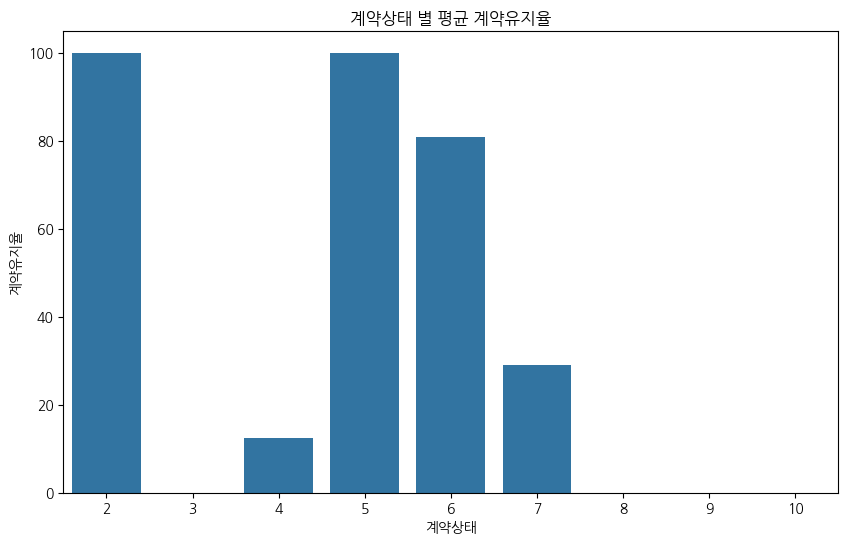

In [251]:
mean_retention_stat = cont_pre6.groupby('INS_CT_STAT_CD')['계약유지율'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='INS_CT_STAT_CD', y='계약유지율', data=mean_retention_stat)
plt.title('계약상태 별 평균 계약유지율')
plt.xlabel('계약상태')
plt.ylabel('계약유지율')
plt.show()

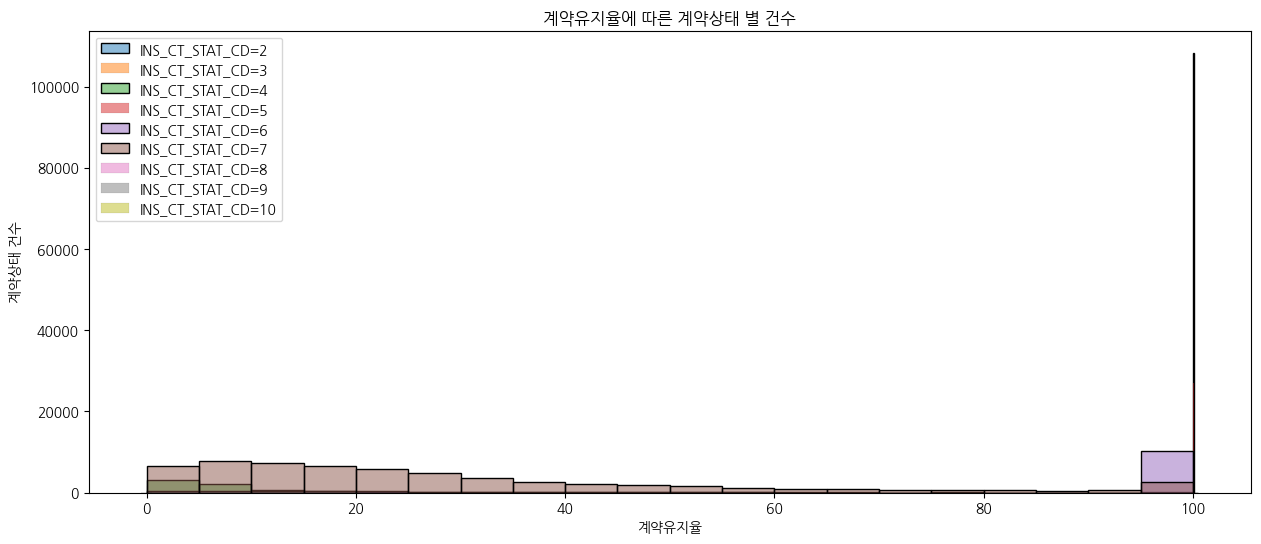

In [255]:
plt.figure(figsize=(15, 6))
for status_code, group_data in cont_pre6.groupby('INS_CT_STAT_CD'):
    sns.histplot(group_data['계약유지율'], bins=20, label=f'INS_CT_STAT_CD={status_code}', alpha=0.5)

plt.title('계약유지율에 따른 계약상태 별 건수')
plt.xlabel('계약유지율')
plt.ylabel('계약상태 건수')
plt.legend()
plt.show()

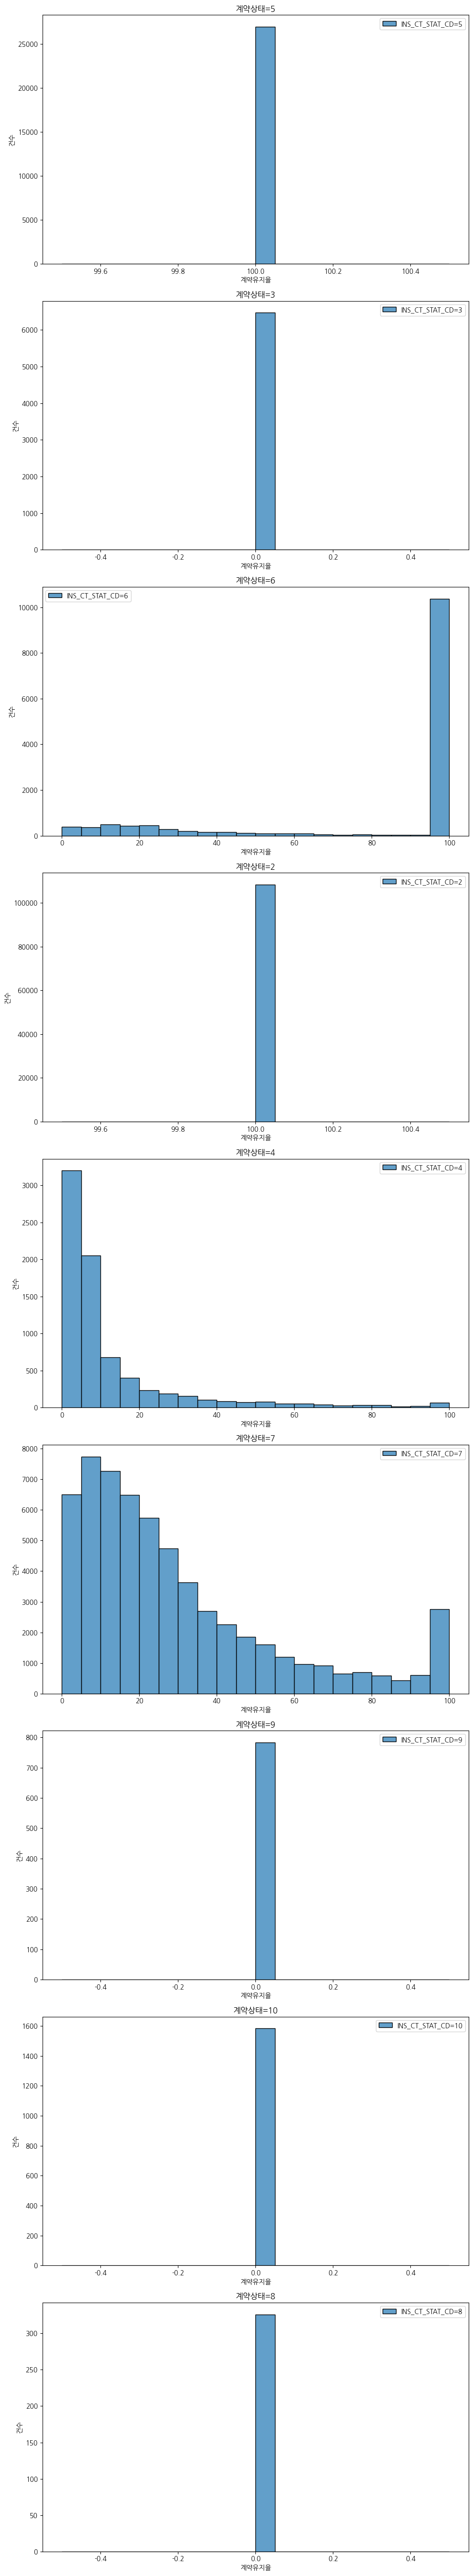

In [254]:
fig, axs = plt.subplots(nrows=len(cont_pre6['INS_CT_STAT_CD'].unique()), figsize=(10, 6 * len(cont_pre6['INS_CT_STAT_CD'].unique())))

# 각 INS_CT_STAT_CD 값에 대한 개별 플롯 작성
for i, status_code in enumerate(cont_pre6['INS_CT_STAT_CD'].unique()):
    sns.histplot(cont_pre6[cont_pre6['INS_CT_STAT_CD'] == status_code]['계약유지율'], bins=20, ax=axs[i], label=f'INS_CT_STAT_CD={status_code}', alpha=0.7)
    axs[i].set_title(f'계약상태={status_code}')
    axs[i].set_xlabel('계약유지율')
    axs[i].set_ylabel('건수')
    axs[i].legend()

plt.tight_layout()
plt.show()

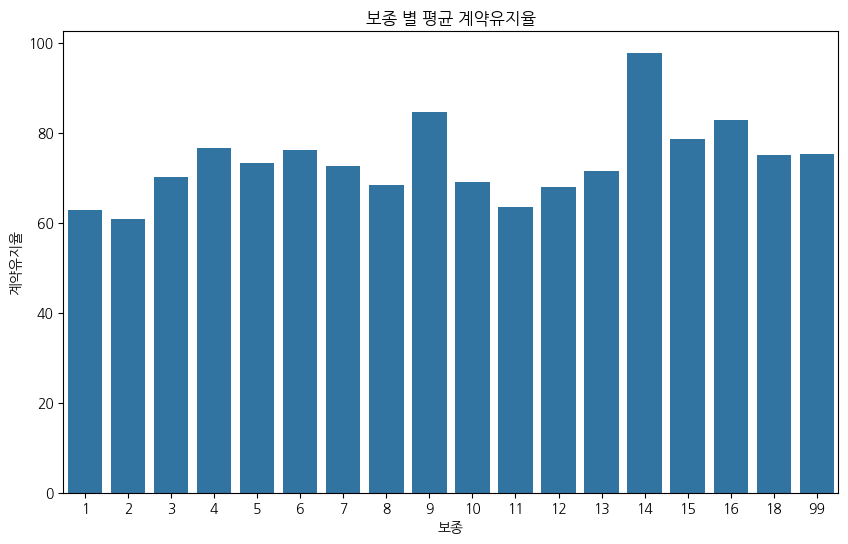

In [250]:
mean_retention_gbn = cont_pre6.groupby('INS_GBN_CD')['계약유지율'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='INS_GBN_CD', y='계약유지율', data=mean_retention_gbn)
plt.title('보종 별 평균 계약유지율')
plt.xlabel('보종')
plt.ylabel('계약유지율')
plt.show()

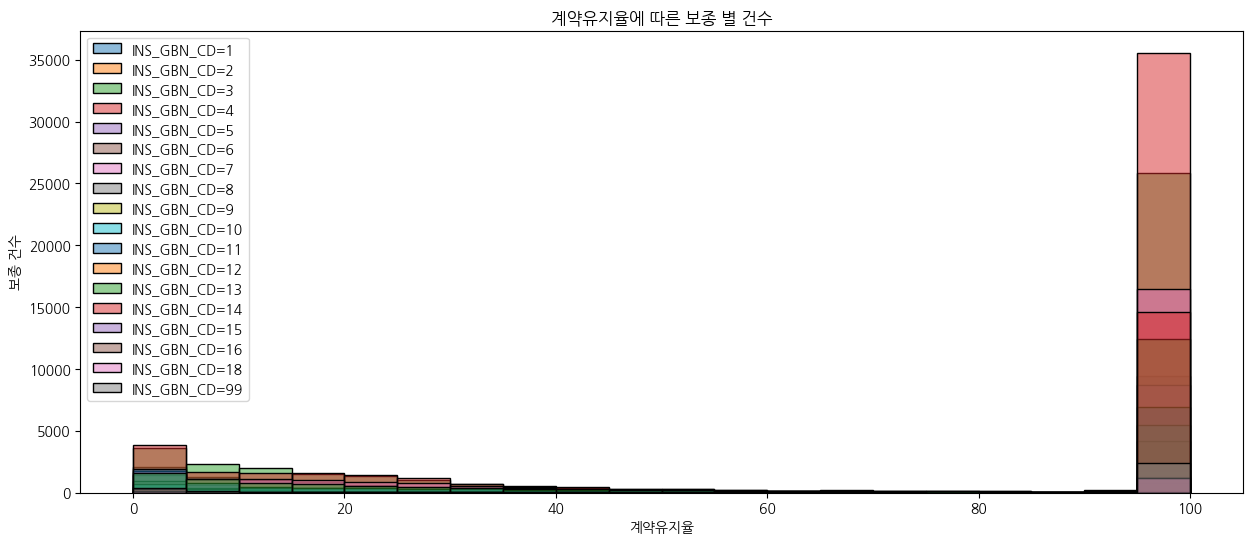

In [257]:
plt.figure(figsize=(15, 6))
for gbn_code, group_data in cont_pre6.groupby('INS_GBN_CD'):
    sns.histplot(group_data['계약유지율'], bins=20, label=f'INS_GBN_CD={gbn_code}', alpha=0.5)

plt.title('계약유지율에 따른 보종 별 건수')
plt.xlabel('계약유지율')
plt.ylabel('보종 건수')
plt.legend()
plt.show()

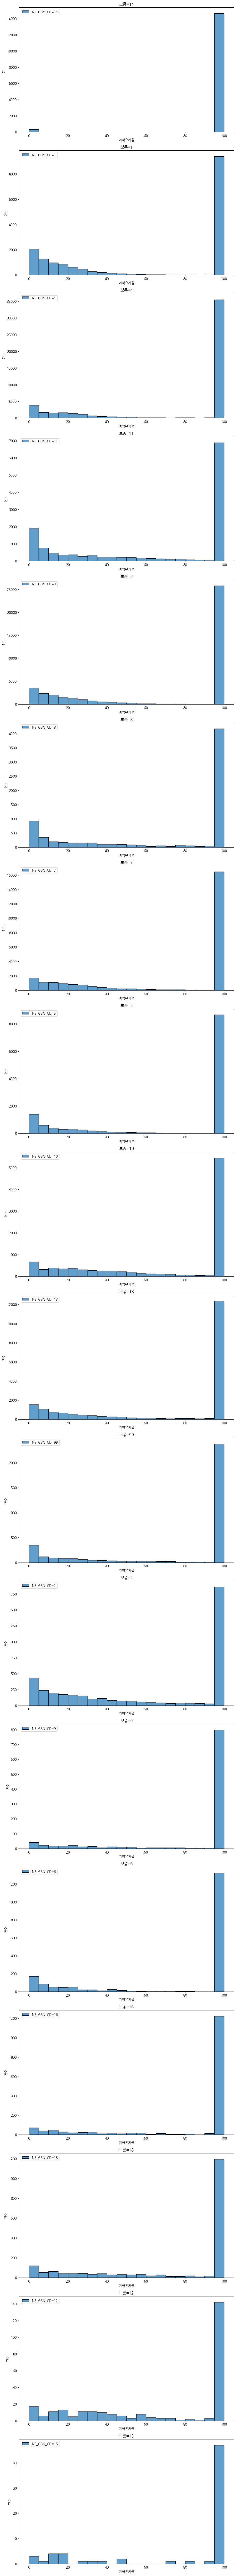

In [258]:
fig, axs = plt.subplots(nrows=len(cont_pre6['INS_GBN_CD'].unique()), figsize=(10, 6 * len(cont_pre6['INS_GBN_CD'].unique())))

# 각 INS_GBN_CD 값에 대한 개별 플롯 작성
for i, gbn_code in enumerate(cont_pre6['INS_GBN_CD'].unique()):
    sns.histplot(cont_pre6[cont_pre6['INS_GBN_CD'] == gbn_code]['계약유지율'], bins=20, ax=axs[i], label=f'INS_GBN_CD={gbn_code}', alpha=0.7)
    axs[i].set_title(f'보종={gbn_code}')
    axs[i].set_xlabel('계약유지율')
    axs[i].set_ylabel('건수')
    axs[i].legend()

plt.tight_layout()
plt.show()